In [1]:
import sys
# import from utils folder, add parent directory
sys.path.insert(0, "../utils")
import utils
import train_eval
import network_samples
import numpy as np
import time
import matplotlib.pyplot as plt
import importlib
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image

# Assignment 5

 - a) Write **Convolutional** Variational Autoencoder for **SVHN** dataset
    - Model:
      - Use Conv. layers for encoder and TransposedConv. layers
      - You are allowed to use one FC-layer in each module for the bottleneck, but it's not necessary
   

In [2]:
root = "./data"

In [3]:
transform_rgb = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

svhn_train_data = SVHN(root=root, split="train", transform=transform_rgb, download=True)
svhn_test_data = SVHN(root=root, split="test", transform=transform_rgb, download=True)

BATCH_SIZE = 512

svhn_train_loader = torch.utils.data.DataLoader(svhn_train_data, batch_size=BATCH_SIZE, shuffle=True)
svhn_test_loader = torch.utils.data.DataLoader(svhn_test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [4]:
len(svhn_train_data)

73257

In [5]:
svhn_train_data.data.shape
svhn_test_data.data.shape

(26032, 3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.0494) tensor(0.4091) torch.Size([3, 32, 32])
tensor(-1.8256) tensor(1.3502) torch.Size([3, 32, 32])
tensor(-1.7754) tensor(0.8179) torch.Size([3, 32, 32])
tensor(-1.7031) tensor(1.0630) torch.Size([3, 32, 32])
tensor(-1.4158) tensor(1.0017) torch.Size([3, 32, 32])


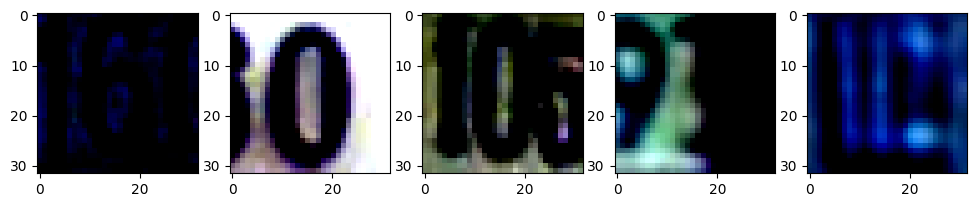

In [6]:
for img, label in svhn_train_loader:
    plt_nums=5
    _, ax = plt.subplots(1,plt_nums,figsize=(12,6))
    for i in range(plt_nums):
        print(img[i].min(), img[i].max(), img[i].shape)
        ax[i].imshow(img[i].permute(1, 2, 0))
    break

In [7]:
def get_act(act_name):
    """ Gettign activation given name """
    assert act_name in ["ReLU", "Sigmoid", "Tanh"]
    activation = getattr(nn, act_name)
    return activation()
    
def get_dropout(drop_p):
    """ Getting a dropout layer """
    if(drop_p):
        drop = nn.Dropout(p=drop_p)
    else:
        drop = nn.Identity()
    return drop


In [8]:
class Encoder(nn.Module):

    def __init__(self, in_size, feature_dims, k_size, batchnorm, pool, act_name) -> None:
        super().__init__()
        # simple convolution setup
        en_convs = []
        en_conv = network_samples.ConvBlock(
            in_channel=in_size[0], out_channel=feature_dims[0], 
            kernel_size=k_size,  batchNorm=batchnorm,
            act_name=act_name, pool=pool
            )
        en_convs.append(en_conv)
        for i in range(len(feature_dims)-1):
            en_conv_block = network_samples.ConvBlock(
                in_channel=feature_dims[i], out_channel=feature_dims[i+1],
                kernel_size=k_size, batchNorm=batchnorm,
                act_name=act_name, pool=pool
            )
            en_convs.append(en_conv_block)
        self.enc_convs = nn.Sequential(*en_convs)
    
    def forward(self, x):
        return self.enc_convs(x)

class Decoder(nn.Module):
    def __init__(self, in_size, feature_dims, batchnorm, act_name, upconvtype="ConvUpsample") -> None:
        super().__init__()
        dec_convs = []
        assert upconvtype in ["ConvUpsample", "ConvTranspose"]
        upconv = network_samples.ConvTransposeBlock if upconvtype == "ConvTranspose" else network_samples.ConvUpsampleBlock
        sizes = torch.tensor([in_size[0], *feature_dims])
        sizes = torch.flip(sizes, dims=(0, ))
        for i in range(len(sizes)-1):
            dec_conv_block = upconv(
                in_channel=sizes[i], out_channel=sizes[i+1],
                batchNorm=batchnorm, act_name=act_name
            )
            dec_convs.append(dec_conv_block)
        self.dec_convs = nn.Sequential(*dec_convs)

    def forward(self, x):
        return self.dec_convs(x)

def make_latent(latent_dim, in_size, feature_dims, pool):
    img_height, img_width = in_size[1], in_size[2]
    # because of maxpool
    if pool == True:
        img_height = img_height // (2 * len(feature_dims))
        img_width = img_width // (2 * len(feature_dims))
    
    # set image dimensions for reduced img size
    in_features = feature_dims[-1] * img_height * img_width
    mu_fc = nn.Linear(in_features=in_features, out_features=latent_dim)
    logvar_fc = nn.Linear(in_features=in_features, out_features=latent_dim)
    dec_fc = nn.Linear(in_features=latent_dim, out_features=in_features)
    return mu_fc, logvar_fc, dec_fc


In [9]:
class ConvVAE(nn.Module):
    """
    Implementaton of a convolutional variational autoencoder for
    the Street View House Numbers dataset.
    """
    def __init__(self, in_size, feature_dims, latent_dim, k_size, act_name, upconvtype, pool=False, batchnorm = False) -> None:
        super().__init__()
        self.in_size = in_size
        self.latent_dim = latent_dim
        self.feature_dims = feature_dims
        self.pool = pool
        
        # makes encoder according to feature size
        self.encoder = Encoder(in_size, feature_dims, k_size, batchnorm, pool, act_name)
        # makes decoder according to feature size
        self.decoder = Decoder(in_size, feature_dims, batchnorm,  act_name, upconvtype)
        # makes decoder in form or linear layer mu and linear layer logvar
        self.mu_fc, self.logvar_fc, self.dec_fc = make_latent(latent_dim, in_size, feature_dims, pool)
    
    def reparameterize(self, mu, logvar):
        # reparameterization trick to sample from the gaussian distr
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def encoder_pass(self, x):
        x_enc = self.encoder(x)
        # pass through latent 
        x_enc = x_enc.view(self.batch_size, -1)
        mu = self.mu_fc(x_enc)
        logvar = self.logvar_fc(x_enc)
        return mu, logvar

    def decoder_pass(self, z, batch_size):
        # pass thorugh decoder bottleneck
        x_dec = self.dec_fc(z)
        # resize after linear layer
        img_height, img_width = self.in_size[-2], self.in_size[-1]
        if self.pool == True:
            img_height = img_height // (2 * len(self.feature_dims))
            img_width = img_width // (2 * len(self.feature_dims))
        x_dec = x_dec.view(batch_size, self.feature_dims[-1], img_height, img_width)
        # pass thorugh decoder
        x_dec = self.decoder(x_dec)
        return x_dec

    def forward(self, x):
        # pass through encoder
        self.batch_size, ch, h, w = x.shape
        mu, logvar = self.encoder_pass(x)
        # reparameterization trick
        z = self.reparameterize(mu, logvar)
        # pass through decoder
        out = self.decoder_pass(z,  self.batch_size)
        return out, mu, logvar

In [10]:
def convvae_loss(outs, imgs, return_full=False):
    out, mu, logvar = outs
    
    r_l = F.mse_loss(out, imgs) * imgs.shape[-1] * imgs.shape[-2]
    kl_l = 0.5 * (logvar.exp() + mu**2 - 1 - logvar).sum(-1).mean()

    return (kl_l + r_l) if return_full==False else (kl_l + r_l, kl_l, r_l)

In [11]:
def convvae_train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    ''' One epoch model training '''
    loss_list, recon_loss, vae_loss = [], [], []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)

        # Clearing gradients
        optimizer.zero_grad()
        # Forward pass
        outs = model(images)
        # Loss
        loss, bce, kld = criterion(outs, images, return_full=True)
        loss_list.append(loss.item())
        recon_loss.append(bce.item())
        vae_loss.append(kld.item())
        # Backward pass - Param gradients
        loss.backward()
        # Updating params
        optimizer.step()

        progress_bar.set_description(f"Epoch {epoch+1} || Iter {i+1} || Loss: {loss.item():.5f}")
        if i == len(train_loader)-1:
            mean_loss = np.mean(loss_list)
            progress_bar.set_description(f"Epoch {epoch+1} || Iter {i+1} || Mean loss: {mean_loss.item():.5f}")

    return mean_loss, loss_list

@torch.no_grad()
def convvae_eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="recons"):
    """ Model evauation for either validation or test """
    loss_list, recon_loss, vae_loss = [], [], []
    for i, (images, labels) in enumerate(eval_loader):
        images = images.to(device)

        # Forward pass
        outs = model(images)
        # Loss
        loss, bce, kld = criterion(outs, images, return_full=True)
        loss_list.append(loss.item())
        recon_loss.append(bce.item())
        vae_loss.append(kld.item())

    mean_loss = np.mean(loss_list)
    mean_recon_loss = np.mean(recon_loss)
    mean_vae_loss = np.mean(vae_loss)
    return mean_loss, mean_recon_loss, mean_vae_loss

def convvae_train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, device, savepath, tboard=None):

    train_loss, val_loss, val_loss_recon, val_loss_vae, loss_iters = [], [], [], [], []
    start = time.time()
    
    for epoch in range(num_epochs):

        model.eval()
        loss, recon_loss, vae_loss = convvae_eval_model(model, valid_loader, criterion, device, epoch, True, savepath)
        val_loss.append(loss)
        val_loss_recon.append(recon_loss)
        val_loss_vae.append(vae_loss)
        if tboard !=None:
            tboard.add_scalar(f'Val loss', loss, global_step=epoch)
            tboard.add_scalar(f'Val rec loss', recon_loss, global_step=epoch)
            tboard.add_scalar(f'Val vae loss', vae_loss, global_step=epoch)

        model.train()
        mean_loss, curr_loss_iter = convvae_train_epoch(model, train_loader, optimizer, criterion, epoch, device)
        # Plateau scheduler
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters += curr_loss_iter
        if tboard != None:
            tboard.add_scalar(f'Train loss', mean_loss, global_step=epoch)

    end = time.time()
    print(f"Training completed after {(end-start)/60.:.2f} minutes")
    return train_loss, val_loss, val_loss_recon, val_loss_vae, loss_iters


In [12]:
in_size = [int(svhn_train_data.data.shape[1]), int(svhn_train_data.data.shape[2]), int(svhn_train_data.data.shape[3])]
feature_dims = [16, 32]
latent_dim = 128
k_size = 5
conv_types = ["ConvUpsample", "ConvTranspose"]
convvae_model = ConvVAE(
    in_size=in_size, feature_dims=feature_dims, latent_dim=latent_dim, 
    k_size=k_size, pool=True, batchnorm=True, act_name="relu",
    upconvtype=conv_types[0]
)

print("ConvVAE params: ", utils.count_parameters(convvae_model))


ConvVAE params:  807977


In [9]:
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 30

importlib.reload(network_samples);

In [14]:
criterion = convvae_loss

# Tensorboard
convvae_tboard = utils.make_tboard_logs("simple_convvae")

convvae_optimizer = torch.optim.Adam(convvae_model.parameters(), lr = LR)
convvae_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(convvae_optimizer, patience=5, factor=0.9, verbose=True)
convvae_model = convvae_model.to(DEVICE)
convvae_train_loss, convvae_val_loss, convvae_val_loss_recon, convvae_val_loss_vae, convvae_loss_iters = convvae_train_model(convvae_model, 
    convvae_optimizer, convvae_scheduler, criterion, svhn_train_loader, svhn_test_loader, NUM_EPOCHS, DEVICE, "recons/convvae_",
    convvae_tboard)

/home/user/gomezruizs0/CL/CudaLab_SGR_PS/Session05/tboard_logs/simple_convvae


Epoch 1 || Iter 144 || Mean loss: 604.53040: 100%|██████████| 144/144 [00:11<00:00, 12.17it/s]
Epoch 2 || Iter 144 || Mean loss: 493.60075: 100%|██████████| 144/144 [00:11<00:00, 12.37it/s]
Epoch 3 || Iter 144 || Mean loss: 477.62205: 100%|██████████| 144/144 [00:11<00:00, 12.34it/s]
Epoch 4 || Iter 144 || Mean loss: 467.53556: 100%|██████████| 144/144 [00:11<00:00, 12.51it/s]
Epoch 5 || Iter 144 || Mean loss: 458.69873: 100%|██████████| 144/144 [00:11<00:00, 12.47it/s]
Epoch 6 || Iter 144 || Mean loss: 452.90666: 100%|██████████| 144/144 [00:11<00:00, 12.55it/s]
Epoch 7 || Iter 144 || Mean loss: 448.44987: 100%|██████████| 144/144 [00:11<00:00, 12.52it/s]
Epoch 8 || Iter 144 || Mean loss: 445.01439: 100%|██████████| 144/144 [00:11<00:00, 12.53it/s]
Epoch 9 || Iter 144 || Mean loss: 443.48737: 100%|██████████| 144/144 [00:11<00:00, 12.37it/s]
Epoch 10 || Iter 144 || Mean loss: 442.67690: 100%|██████████| 144/144 [00:11<00:00, 12.35it/s]
Epoch 11 || Iter 144 || Mean loss: 440.82589: 100

Training completed after 7.59 minutes


In [ ]:
utils.save_model(convvae_model, convvae_optimizer, 30, [convvae_train_loss, convvae_val_loss, convvae_val_loss_recon, convvae_val_loss_vae, convvae_loss_iters])

In [14]:
convvae_loaded = ConvVAE(
    in_size=in_size, feature_dims=feature_dims, latent_dim=latent_dim, 
    k_size=k_size, pool=True, batchnorm=True, act_name="relu",
    upconvtype=conv_types[0]
)

convvae_loaded_optim = torch.optim.Adam(convvae_loaded.parameters(), lr = LR)
# convae_loaded, convae_loaded_optim, _, _ = utils.load_model(convvae_loaded, convvae_loaded_optim, "./models/checkpoint_ConvVAE_epoch_30.pth")
convae_loaded, convae_loaded_optim, _, _ = utils.load_model(convvae_loaded, convvae_loaded_optim, "./models/checkpoint_ConvVAE_epoch_30_latent_128.pth")

convae_loaded.to(DEVICE);

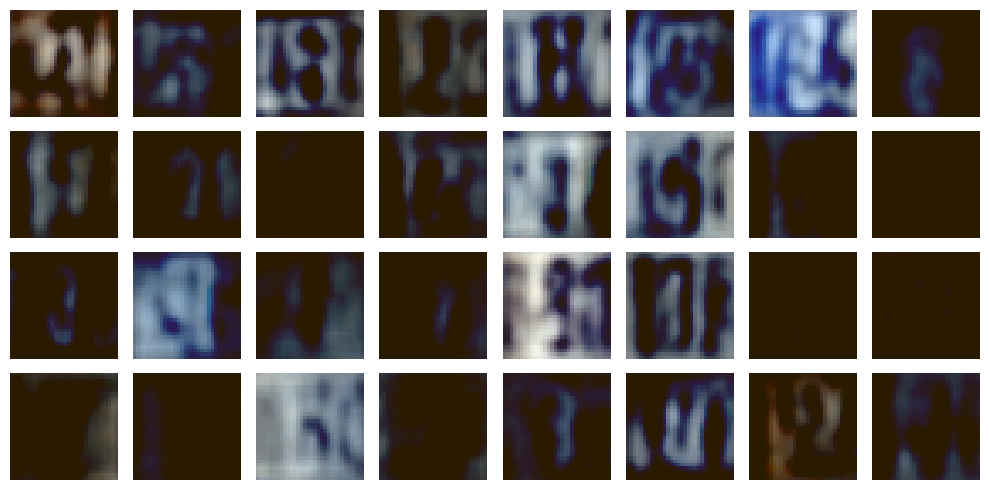

In [15]:
def plot_generated_by_label_random_generated_samples(model):
    with torch.no_grad():
        model.to("cpu")
        model.eval()
        num_samples = 32
        samples = torch.randn(num_samples, latent_dim)
        recon_samples = model.decoder_pass(samples, num_samples).cpu()
    
    mean = torch.tensor([0.485, 0.456, 0.406])[None, :, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[None, :, None, None]
    recon_samples = recon_samples * std + mean
    
    # peter-black normalization
    recon_samples -= recon_samples.min()
    recon_samples /= recon_samples.max()
    
    _, ax = plt.subplots(num_samples//8, 8, figsize=(10, 5))
    for i in range(num_samples):
        ax[i//8][i % 8].imshow(recon_samples[i].cpu().permute(1, 2, 0))
        ax[i//8][i % 8].axis("off")

    plt.tight_layout()
    plt.show()

plot_generated_by_label_random_generated_samples(convvae_loaded)

This plot shows random generation of images on the SVHN dataset. we can see that some images are completely black while other images try to show some numbers, but it is blurred out completely.

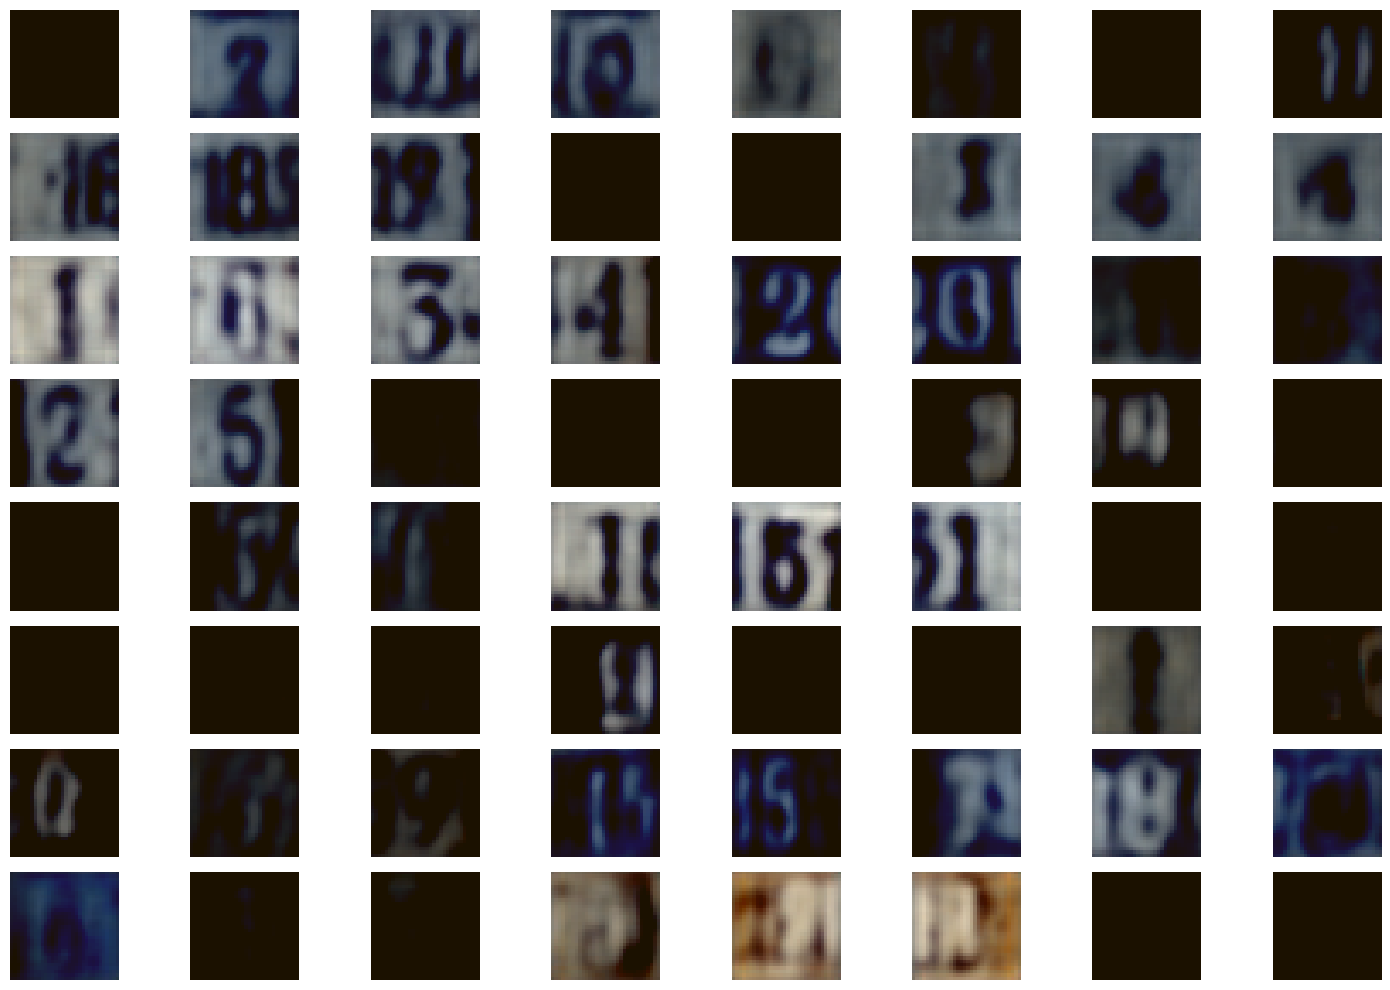

In [16]:
def plot_generated_by_label_from_dataset(model):
    
    num_samples = 64
    _, ax = plt.subplots(num_samples//8, 8, figsize=(15, 10))
    for image, label in svhn_test_loader:
        model.eval()
        recon_samples, mu, logvar = model(image)
        mean = torch.tensor([0.485, 0.456, 0.406])[None, :, None, None]
        std = torch.tensor([0.229, 0.224, 0.225])[None, :, None, None]
        recon_samples = recon_samples.cpu() * std + mean

        # ptrblck normalization
        recon_samples -= recon_samples.min()
        recon_samples /= recon_samples.max()

        for i, img in enumerate(recon_samples[:num_samples]):
            ax[i//8][i % 8].imshow(img.detach().permute(1, 2, 0).numpy())
            ax[i//8][i % 8].axis("off")
        break
    plt.tight_layout()
    plt.show()

plot_generated_by_label_from_dataset(convvae_loaded)

This plot shows some simple reconstruction of images in the SVHN dataset.

 - b) Implement a Conditional Variational Autoencoder, which generates images based on a given class. Show the capabilities of your model.

In [10]:
class CondConvVAE(nn.Module):
    """
    Implementaton of a convolutional variational autoencoder for
    the Street View House Numbers dataset.
    """
    def __init__(
        self, in_size, feature_dims, latent_dim, 
        num_classes, k_size, act_name, upconvtype="ConvUpsample", 
        pool=False, batchnorm = False):
        super().__init__()
        self.in_size = in_size
        self.latent_dim = latent_dim
        self.feature_dims = feature_dims
        self.pool = pool
        self.num_classes = num_classes
        
        # makes encoder according to feature size
        self.encoder = Encoder(in_size, self.feature_dims, k_size, batchnorm, pool, act_name)
        # makes decoder according to feature size
        self.decoder = Decoder(in_size, feature_dims, batchnorm, act_name, upconvtype)
        # makes decoder in form or linear layer mu and linear layer logvar
        self.mu_fc, self.logvar_fc, self.dec_fc = self._make_latent()

    def _make_latent(self):
        img_height, img_width = in_size[1], in_size[2]
        # because of maxpool
        if self.pool == True:
            img_height = img_height // (2 * len(feature_dims))
            img_width = img_width // (2 * len(feature_dims))
        
        # set image dimensions for reduced img size
        in_features = feature_dims[-1] * img_height * img_width
        mu_fc = nn.Linear(in_features=in_features, out_features=self.latent_dim)
        logvar_fc = nn.Linear(in_features=in_features, out_features=self.latent_dim)
        dec_fc = nn.Linear(in_features=self.latent_dim + self.num_classes, out_features=in_features)
        return mu_fc, logvar_fc, dec_fc

    def condition(self, x, y):
        '''
        Added as a function for possible modularity, though here the encoder and
        decoder initialization would have to be modified as well, since right now
        it's made for one-hot encoding of the labels
        '''
        x_conditioned = torch.cat([x, y], dim=1)
        return x_conditioned
    
    def reparameterize(self, mu, logvar):
        # reparameterization trick to sample from the gaussian distr
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def encoder_pass(self, x):
        x_enc = self.encoder(x)
        # pass through latent 
        x_enc = x_enc.view(self.batch_size, -1)
        mu = self.mu_fc(x_enc)
        logvar = self.logvar_fc(x_enc)
        return mu, logvar

    def decoder_pass(self, z, batch_size, attrs):
        # conditional VAE part, concatenate the attributes to latent vectors
        z = self.condition(z, attrs)
        # pass through decoder bottleneck
        x_dec = self.dec_fc(z)
        # resize after linear layer
        img_height, img_width = self.in_size[-2], self.in_size[-1]
        if self.pool == True:
            img_height = img_height // (2 * len(self.feature_dims))
            img_width = img_width // (2 * len(self.feature_dims))
        x_dec = x_dec.view(batch_size, self.feature_dims[-1], img_height, img_width)
        # pass through decoder
        x_dec = self.decoder(x_dec)
        return x_dec

    def forward(self, x, attrs):
        # pass through encoder
        self.batch_size, ch, h, w = x.shape
        mu, logvar = self.encoder_pass(x)
        # reparameterization trick
        z = self.reparameterize(mu, logvar)
        # pass through decoder
        out = self.decoder_pass(z, self.batch_size, attrs)
        return out, mu, logvar

In [18]:
# Transforms
mnist_tf = T.ToTensor()

# Dataset FMNIST
train_dataset = FashionMNIST(root='./data', train=True, transform=mnist_tf, download=True);
test_dataset = FashionMNIST(root='./data', train=False, transform=mnist_tf);

print(f"Train: {len(train_dataset)}, Test {len(test_dataset)}")

Train: 60000, Test 10000


In [19]:
# Constants 
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(train_dataset.classes)
NUM_EPOCHS = 30

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Tensorboard
cvae_tboard = utils.make_tboard_logs("simple_cvae")

# Model params
in_size = [1, train_dataset.data.shape[-2], train_dataset.data.shape[-1]]
feature_dims = [16, 32]
latent_dim = 2
k_size = 5
conv_types = ["ConvUpsample", "ConvTranspose"]

# Model
cvae = CondConvVAE(
    in_size=in_size, feature_dims=feature_dims, latent_dim=latent_dim, 
    k_size=k_size, pool=True, batchnorm=True, act_name="relu",
    num_classes=NUM_CLASSES)

cvae = cvae.to(DEVICE)

f"Model num parameters: {utils.count_parameters(cvae)}"

/home/user/gomezruizs0/CL/CudaLab_SGR_PS/Session05/tboard_logs/simple_cvae


'Model num parameters: 44807'

In [11]:
def cvae_train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    ''' One epoch model training '''
    loss_list, recon_loss, vae_loss = [], [], []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        one_hot_labels = utils.one_hot(labels, NUM_CLASSES)
        one_hot_labels = one_hot_labels.to(device)
        # Clearing gradients
        optimizer.zero_grad()
        # Forward pass
        outs = model(images, one_hot_labels)
        # Loss
        loss, mse, kld = criterion(outs, images, return_full=True)
        loss_list.append(loss.item())
        recon_loss.append(mse.item())
        vae_loss.append(kld.item())
        # Backward pass - Param gradients
        loss.backward()
        # Updating params
        optimizer.step()

        progress_bar.set_description(f"Epoch {epoch+1} || Iter {i+1} || Loss: {loss.item():.5f}")
        if i == len(train_loader)-1:
            mean_loss = np.mean(loss_list)
            progress_bar.set_description(f"Epoch {epoch+1} || Iter {i+1} || Mean loss: {mean_loss.item():.5f}")

    return mean_loss, loss_list

@torch.no_grad()
def cvae_eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="recons"):
    """ Model evauation for either validation or test """
    loss_list, recon_loss, vae_loss = [], [], []
    for i, (images, labels) in enumerate(eval_loader):
        images = images.to(device)
        one_hot_labels = utils.one_hot(labels, NUM_CLASSES)
        one_hot_labels = one_hot_labels.to(device)
        # Forward pass
        outs = model(images, one_hot_labels)
        # Loss
        loss, mse, kld = criterion(outs, images, return_full=True)
        loss_list.append(loss.item())
        recon_loss.append(mse.item())
        vae_loss.append(kld.item())

        if (i == 0 and savefig):
            with torch.no_grad():
                cond = torch.eye(model.num_classes, model.num_classes).cuda()
                # latent dim from model parameters
                samples = torch.randn(model.num_classes, latent_dim).to(device)
                recon_samples = model.decoder_pass(samples, model.num_classes, cond).cpu()
                save_image(recon_samples.view(model.num_classes, *model.in_size),
                            f'{savepath}reconstructed-epoch-{epoch}.png')

    mean_loss = np.mean(loss_list)
    mean_recon_loss = np.mean(recon_loss)
    mean_vae_loss = np.mean(vae_loss)
    return mean_loss, mean_recon_loss, mean_vae_loss

def cvae_train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, device, savepath, tboard=None):

    train_loss, val_loss, val_loss_recon, val_loss_vae, loss_iters = [], [], [], [], []
    start = time.time()
    
    for epoch in range(num_epochs):

        model.eval()
        loss, recon_loss, vae_loss = cvae_eval_model(model, valid_loader, criterion, device, epoch, True, savepath)
        val_loss.append(loss)
        val_loss_recon.append(recon_loss)
        val_loss_vae.append(vae_loss)
        if tboard !=None:
            tboard.add_scalar(f'Val loss', loss, global_step=epoch)
            tboard.add_scalar(f'Val rec loss', recon_loss, global_step=epoch)
            tboard.add_scalar(f'Val vae loss', vae_loss, global_step=epoch)

        model.train()
        mean_loss, curr_loss_iter = cvae_train_epoch(model, train_loader, optimizer, criterion, epoch, device)
        # Normal scheduler
        # scheduler.step()
        # Plateau scheduler
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters += curr_loss_iter
        if tboard != None:
            tboard.add_scalar(f'Train loss', mean_loss, global_step=epoch)

    end = time.time()
    print(f"Training completed after {(end-start)/60.:.2f} minutes")
    return train_loss, val_loss, val_loss_recon, val_loss_vae, loss_iters

In [23]:
cvae_optimizer = torch.optim.Adam(cvae.parameters(), lr = LR)
cvae_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cvae_optimizer, patience=5, factor=0.9, verbose=True)
cvae_train_loss, cvae_val_loss, cvae_val_loss_recon, cvae_val_loss_vae, cvae_loss_iters = cvae_train_model(cvae, 
    cvae_optimizer, cvae_scheduler, convvae_loss, train_loader, test_loader, NUM_EPOCHS, DEVICE, "recons/cvae_",
    cvae_tboard)

Epoch 1 || Iter 118 || Mean loss: 107.46555: 100%|██████████| 118/118 [00:05<00:00, 21.08it/s]
Epoch 2 || Iter 118 || Mean loss: 52.58985: 100%|██████████| 118/118 [00:05<00:00, 21.32it/s]
Epoch 3 || Iter 118 || Mean loss: 45.60755: 100%|██████████| 118/118 [00:05<00:00, 21.67it/s]
Epoch 4 || Iter 118 || Mean loss: 42.69767: 100%|██████████| 118/118 [00:05<00:00, 21.57it/s]
Epoch 5 || Iter 118 || Mean loss: 40.56438: 100%|██████████| 118/118 [00:05<00:00, 20.73it/s]
Epoch 6 || Iter 118 || Mean loss: 39.00149: 100%|██████████| 118/118 [00:05<00:00, 21.54it/s]
Epoch 7 || Iter 118 || Mean loss: 36.97473: 100%|██████████| 118/118 [00:05<00:00, 21.02it/s]
Epoch 8 || Iter 118 || Mean loss: 35.10648: 100%|██████████| 118/118 [00:05<00:00, 20.44it/s]
Epoch 9 || Iter 118 || Mean loss: 33.91809: 100%|██████████| 118/118 [00:05<00:00, 21.11it/s]
Epoch 10 || Iter 118 || Mean loss: 33.46507: 100%|██████████| 118/118 [00:05<00:00, 20.48it/s]
Epoch 11 || Iter 118 || Mean loss: 33.03035: 100%|████████

Training completed after 3.16 minutes


In [24]:
utils.save_model(cvae, cvae_optimizer, 30, [cvae_train_loss, cvae_val_loss, cvae_val_loss_recon, cvae_val_loss_vae, cvae_loss_iters])

In [21]:
cvae_loaded = CondConvVAE(
    in_size=in_size, feature_dims=feature_dims, latent_dim=latent_dim, 
    k_size=k_size, pool=True, batchnorm=True, act_name="relu",
    num_classes=NUM_CLASSES)
cvae_loaded_optim = torch.optim.Adam(cvae_loaded.parameters(), lr = LR)

# cvae_loaded, cvae_loaded_optim, _, _ = utils.load_model(cvae_loaded, cvae_loaded_optim, "./models/checkpoint_CondConvVAE_epoch_30.pth")
cvae_loaded, cvae_loaded_optim, _, _ = utils.load_model(cvae_loaded, cvae_loaded_optim, "./models/checkpoint_CondConvVAE_epoch_30_fmnist.pth")
cvae_loaded = cvae_loaded.to(DEVICE)

## Observations CVAE

### FMNIST Dataset 

In the "recons" folder we left the resulting images of the reconstruction made for an image of each data class from the FMNIST dataset for every epoch. The given data for the reconstruction is the one hot encoded version of the label of the class desired to reconstruct (actually to be generated) and a tensor of size of the image filled with noise drawn from a normal distribution. This can be observed for the initial epoch, which are basically "empty" images, after the first epochs (let's say around 3) the network is clearly learning and generating some kind of deformed and abstract representations of the classes the we actually expect, but it keeps improving, and around epoch 8 it's already generating images that we could consider decent for the given classes. This keeps getting better after every epoch, and we can observe in the different results that some different "styles" so to say are generated for the multiple classes. And in some occasions, we can still observe some still kind of abstract results, but not as abstract as in the beginning of the training, and most of them recognizable.

Regarding the losses, for both the Convolutional VAE and this conditional VAE, that after all it's also convolutional, there's not much to observe, but the values are logged and their corresponding plots can be seen in the tensorboard logs. As we can see during the training, the losses just keep decreasing through the training, but after the 30 epochs on each model, they are already sort of plateauing.

 - c) Investigate latent space and visualize some interpolations

### Generating images and plotting by class
With the following code snippet (taken from the lecture as well) we can visualize images generated for a particular class (label), and we plot them results for all the possible labels. Clearly out of the 20 generated images plotted for every class, most of them can be identifiable as the mentioned label, nevertheless it can also be seen some similarity between the different classes of top clothes, such as shirt, t-shirt, pullover, dress, but that is expected, and still they are obviously different. And also to note that in some occasions, just some quite abstract and unidentifiable image blobs are generated regardless of the class, which we believe could be improved with more training, with either a deeper or bigger architecture, etc. But we still consider the obtained results, for a model trained so quickly (Around 4 minutes for the 30 Epochs), good enough.

In [17]:
def plot_generated_by_label(model, label):
    with torch.no_grad():
        num_samples = 20
        # Doing the one hot encoding for the desired class (label)
        cond = torch.zeros(num_samples, model.num_classes).to(DEVICE)
        cond[:, label] = 1
        # latent_dim from prior init for model
        samples = torch.randn(num_samples, latent_dim).to(DEVICE)
        recon_samples = model.decoder_pass(samples, num_samples, cond).cpu()
        # save_image(recon_samples.view(num_samples, *cvae.in_size),
        #             f'./recons/recons_c5_class_{label}.png')

    recons = recon_samples.view(num_samples, 1, 28, 28)
    plt.figure(figsize=(10*2, 2*2))
    for i in range(num_samples):
        plt.subplot(2,10,i+1)
        plt.imshow(recons[i, 0].cpu(), cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Plots generated from class:  T-shirt/top


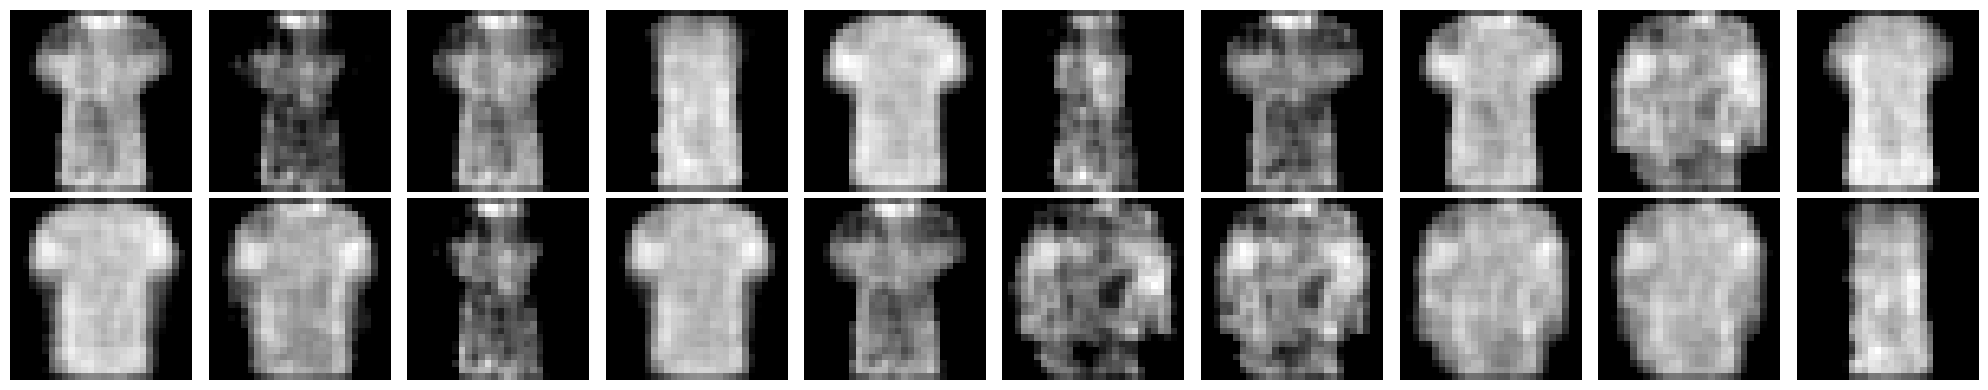

Plots generated from class:  Trouser


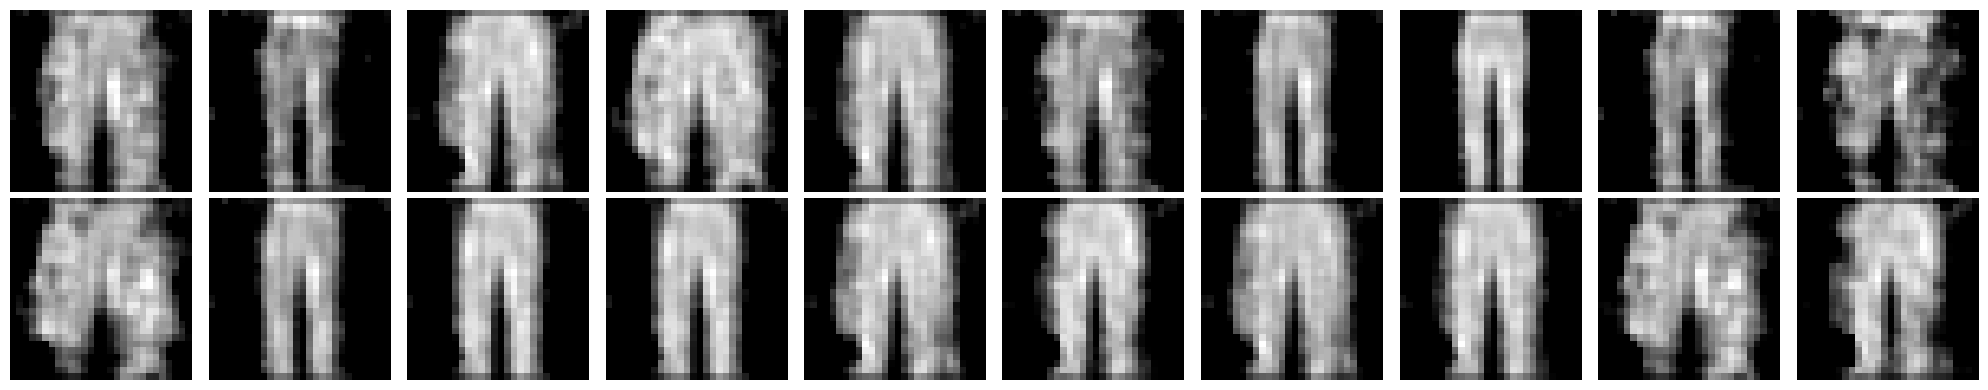

Plots generated from class:  Pullover


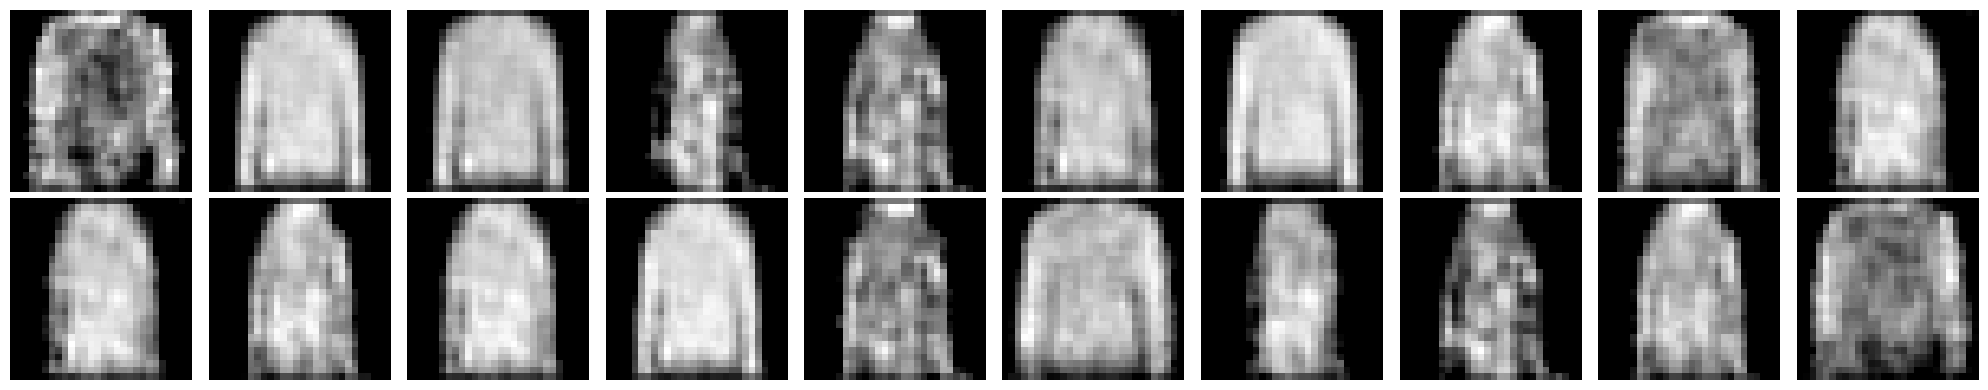

Plots generated from class:  Dress


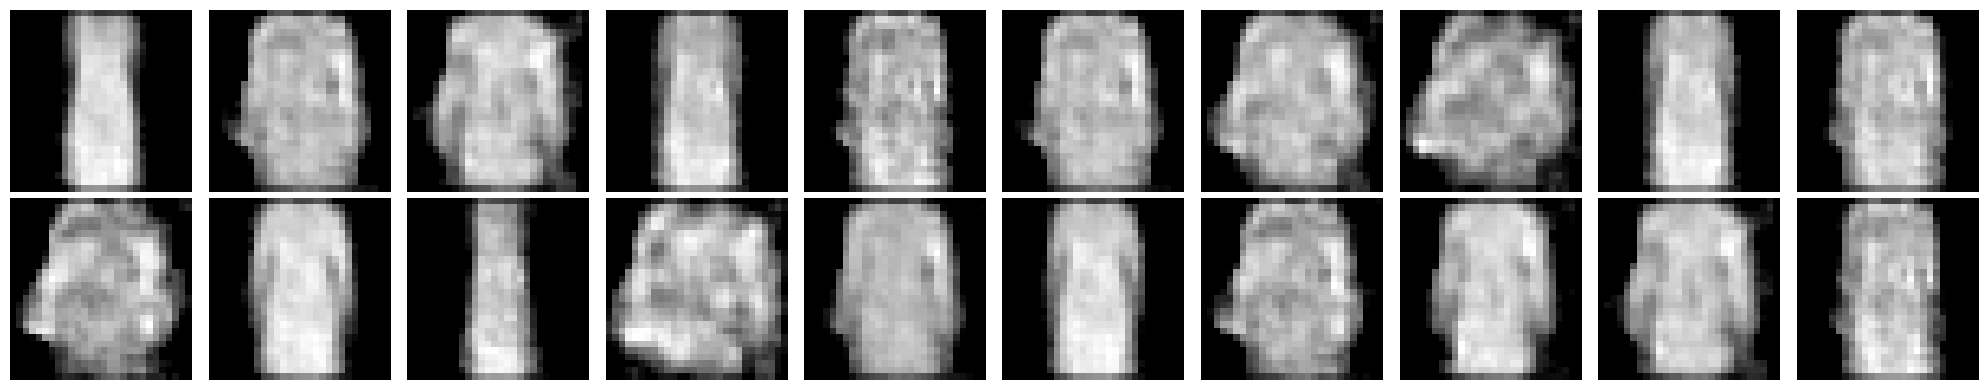

Plots generated from class:  Coat


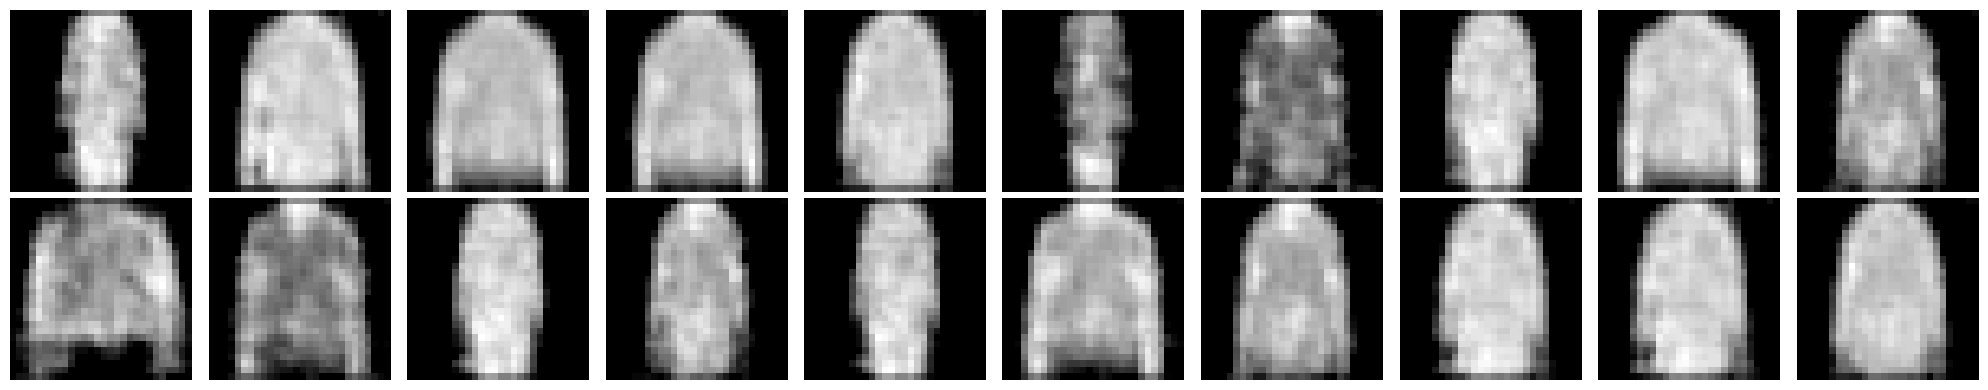

Plots generated from class:  Sandal


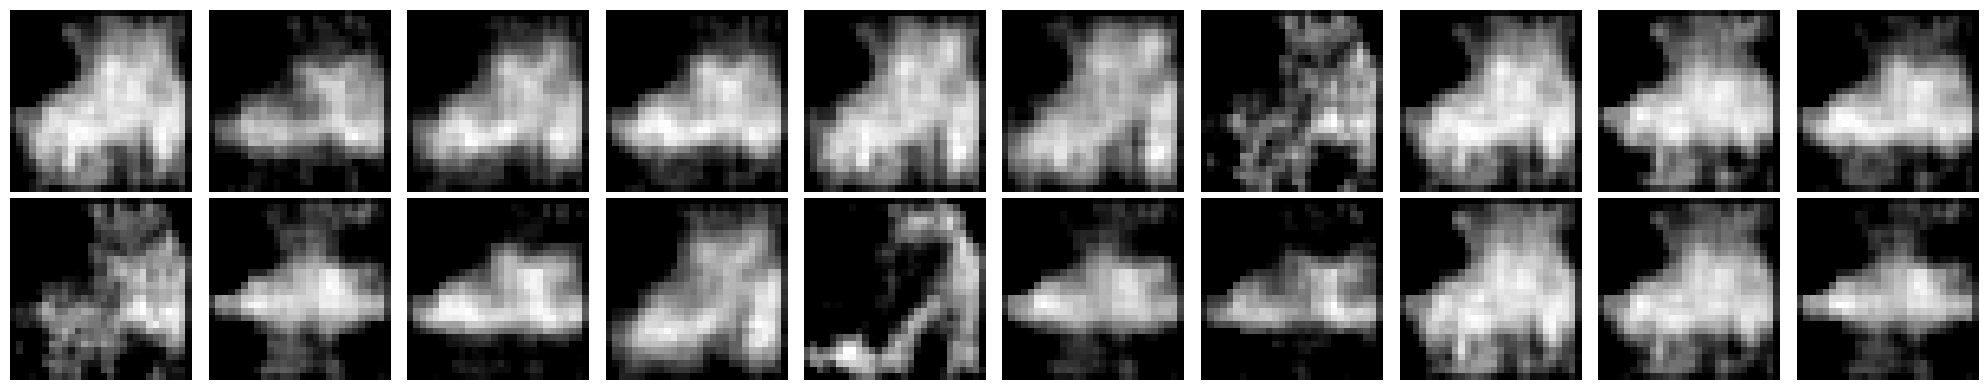

Plots generated from class:  Shirt


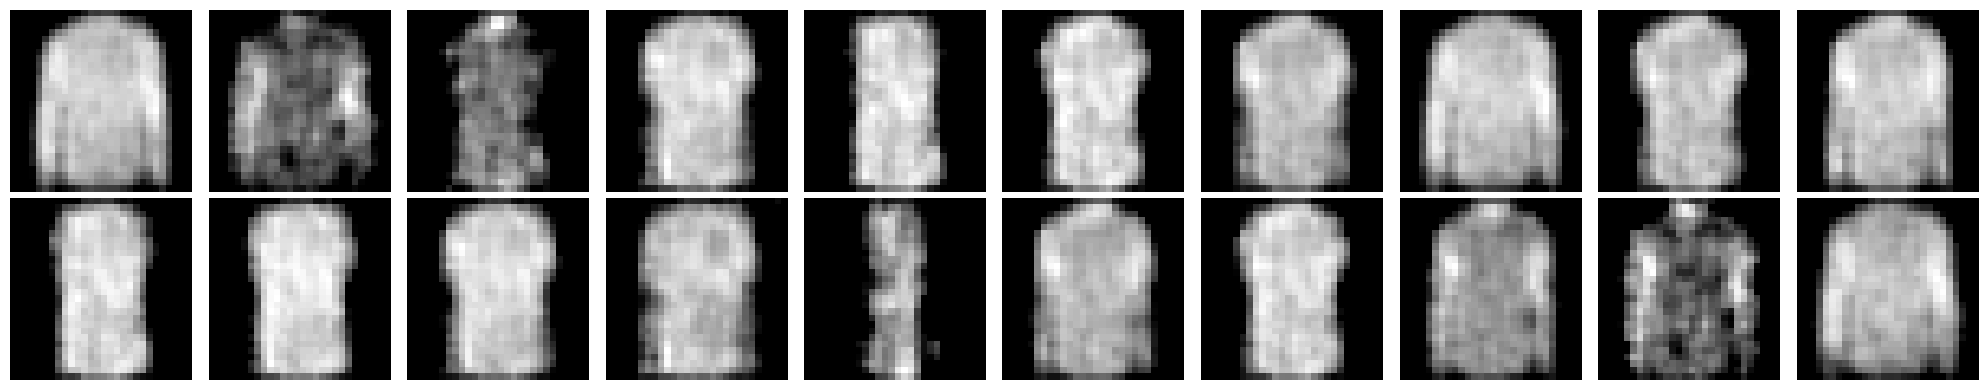

Plots generated from class:  Sneaker


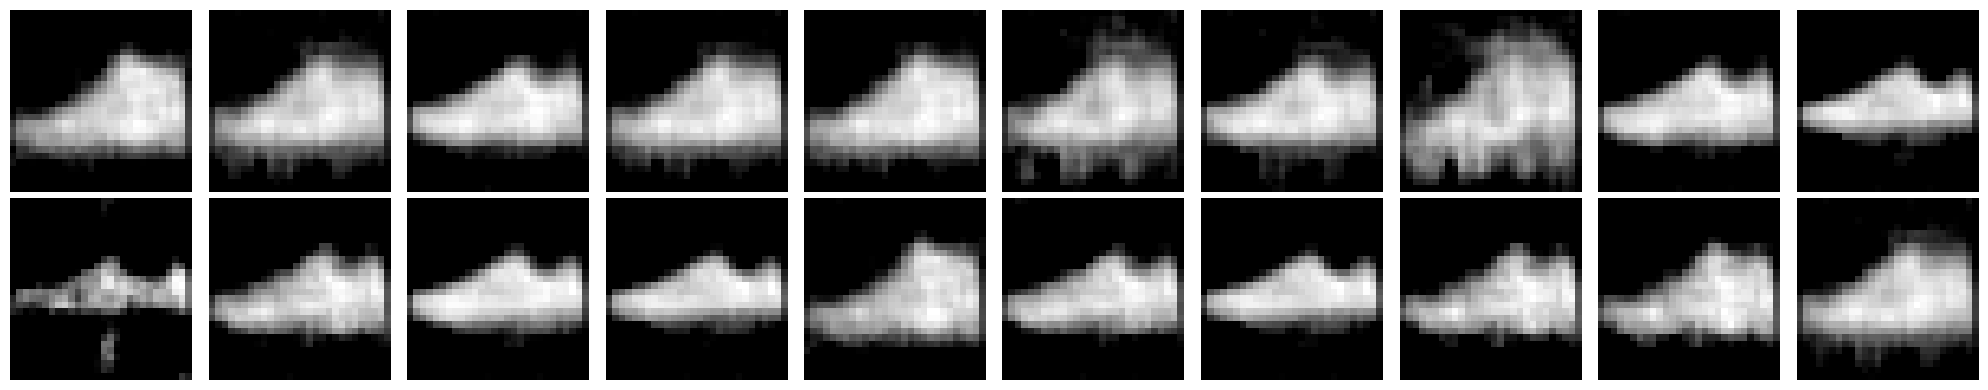

Plots generated from class:  Bag


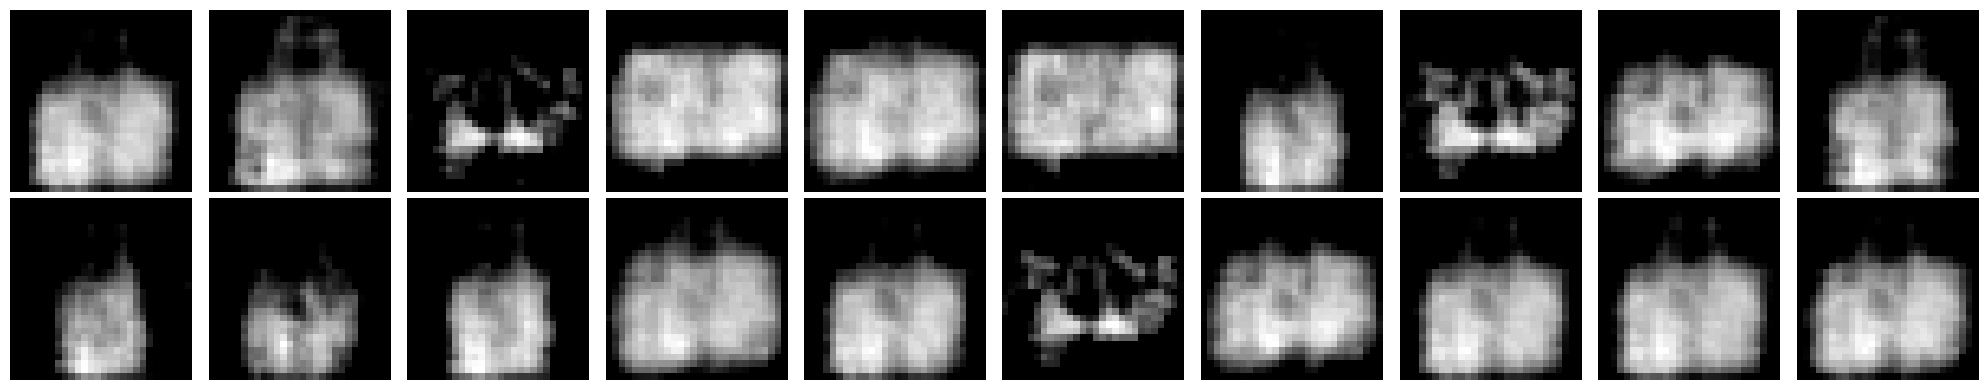

Plots generated from class:  Ankle boot


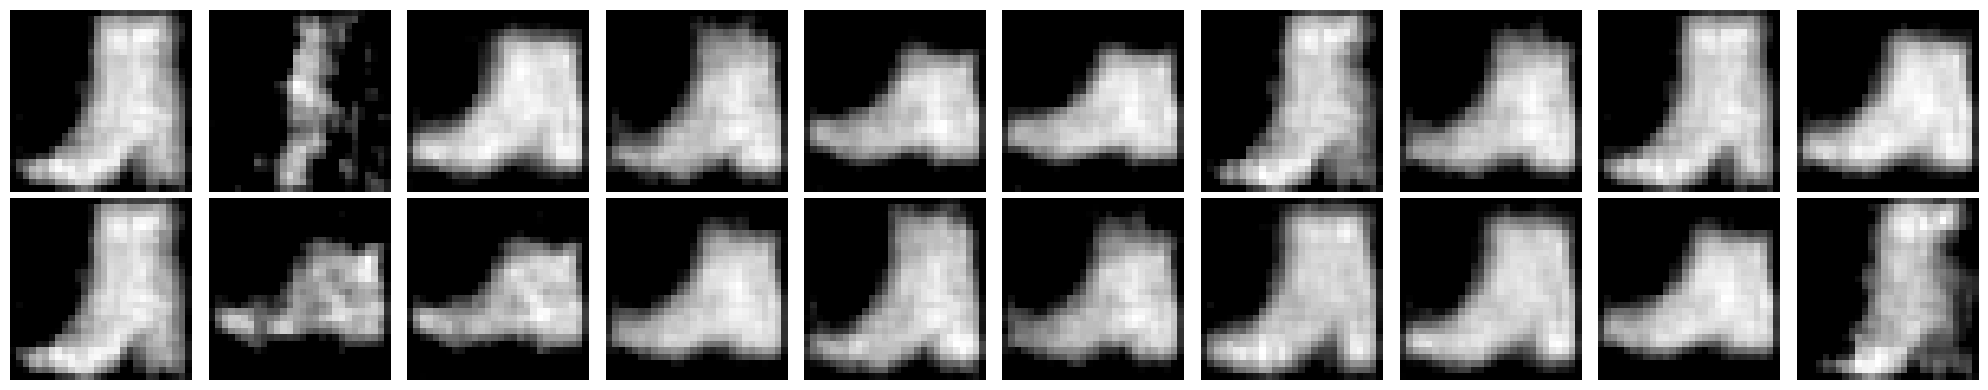

In [24]:
for class_idx, c in enumerate(train_dataset.classes):
    print("Plots generated from class: ", c)
    plot_generated_by_label(cvae_loaded, class_idx)

### Latent space exploration
We visualize the latent space, using some ranges for both of the values of the latent space, since we defined as 2 dimensional for this purpose. Below we show the latent space representation for a few of the classes. For example for trousers, we can see that the "good" representations are more on the bottom side of it, and that the changes for good representations are mostly due to the latent variable represented in the x dimension, affecting the width of the pants and the space in between the legs. Clearly also the models around the mean (middle of the image) are the best learned representations, and the most common for any of the generated class. On the case of the pullover, around the mean is the better representation, and we can see that even the top side of the latent space is in this occasion not neccessarily considered a Pullover to us, but rather some blob of the size of one. An interesting example is sandals, in which we can observe the variance between the different possibilities to be generated, from going to the possibilities of latent variables being flat sandals around the mean of the space, and going to the upper and right possibilites, being sandals with high heels. This is also basically the interpolation analysis, if we were to take values in the line from the center of this latent space (x = 0, y = 0) to the top right corner (x = 2, y = 2).

Latent space for class:  Trouser


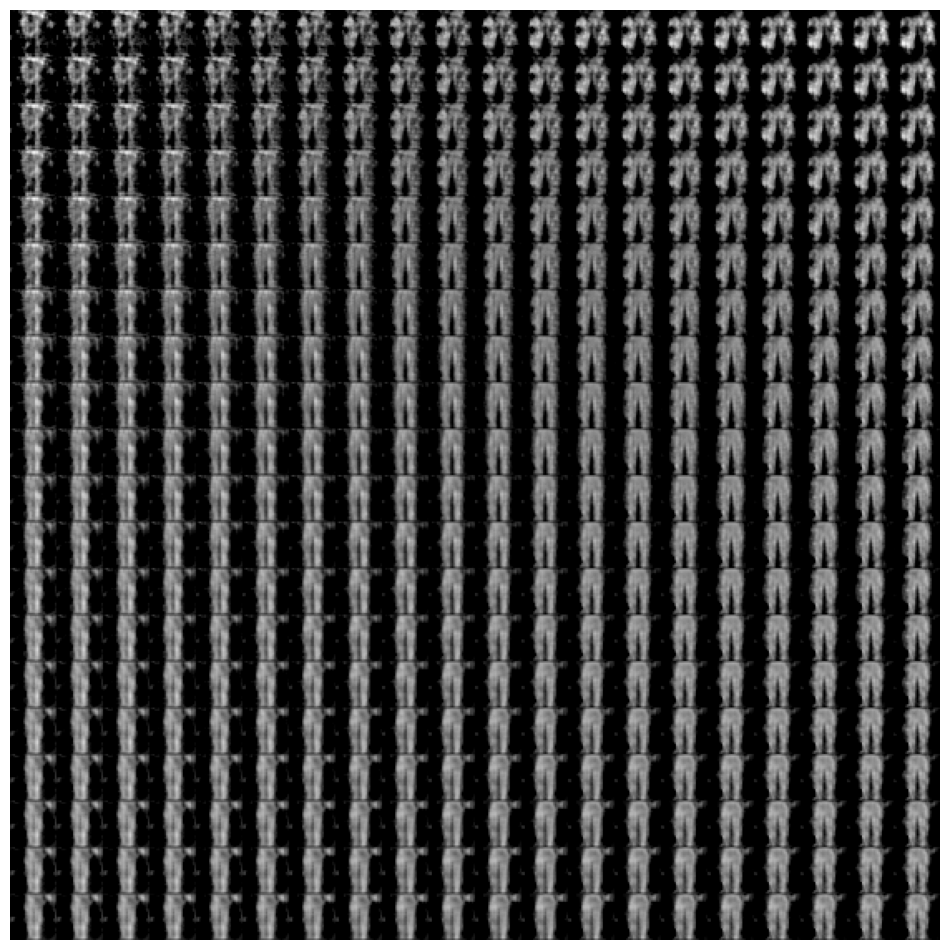

Latent space for class:  Pullover


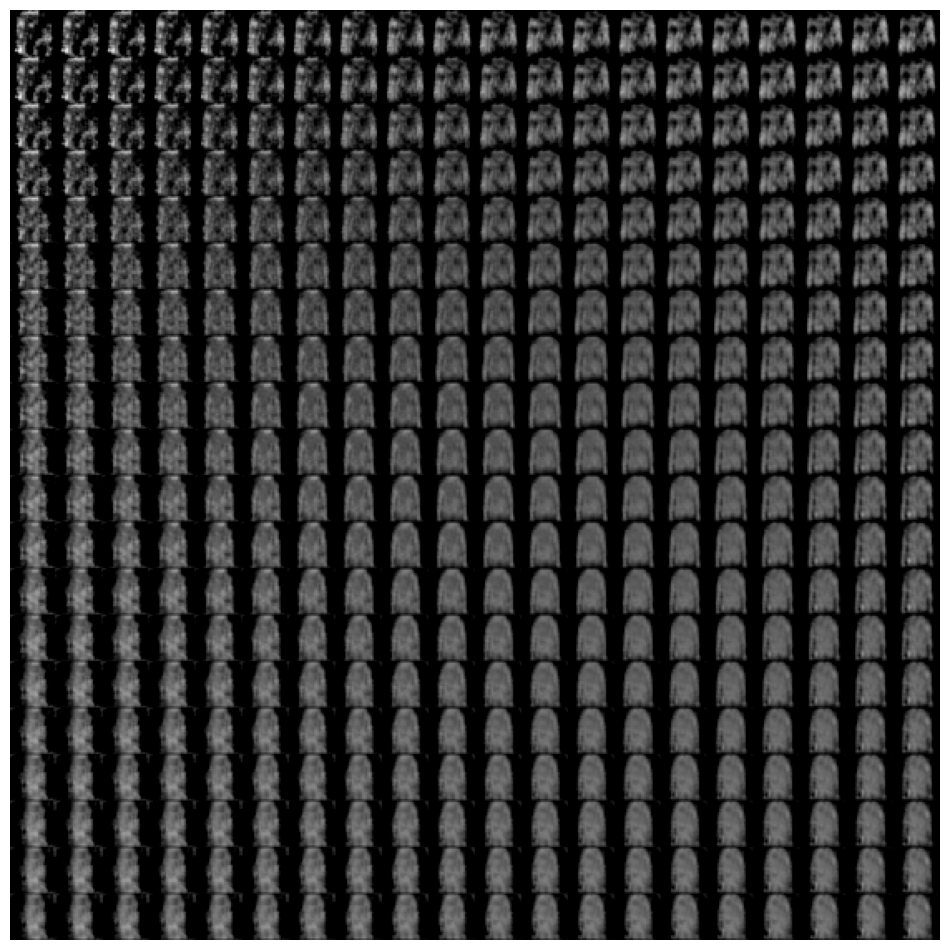

Latent space for class:  Sandal


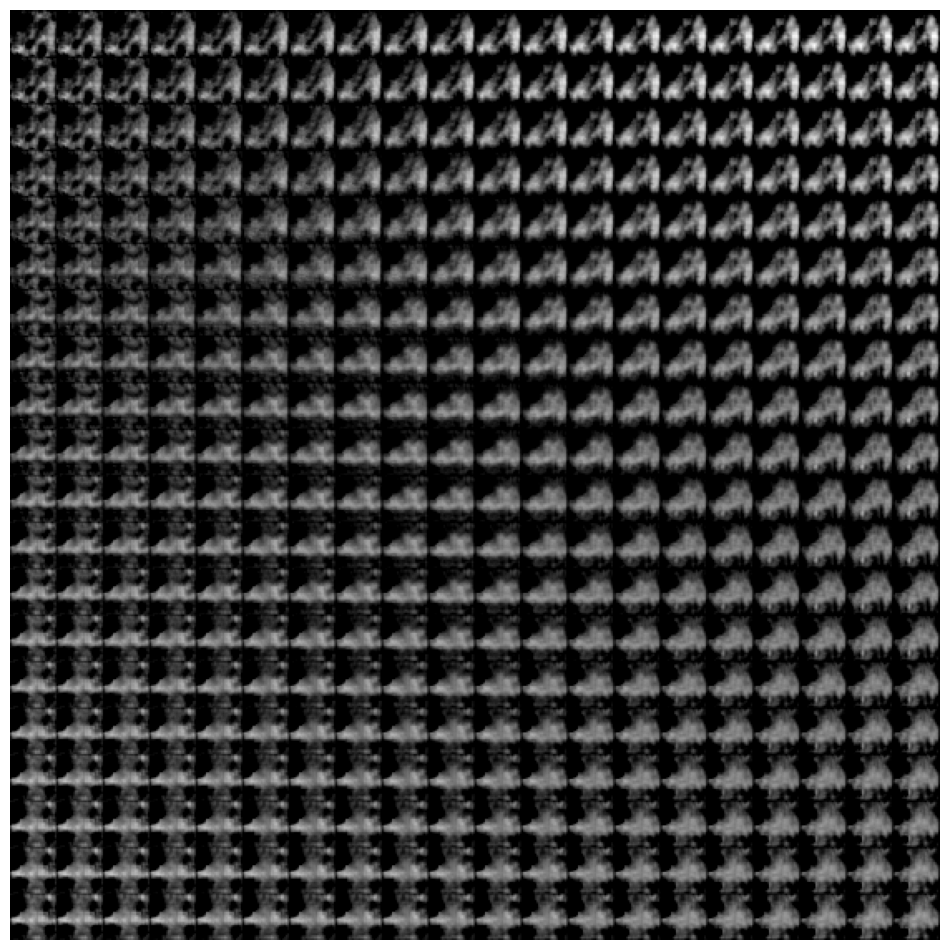

Latent space for class:  Bag


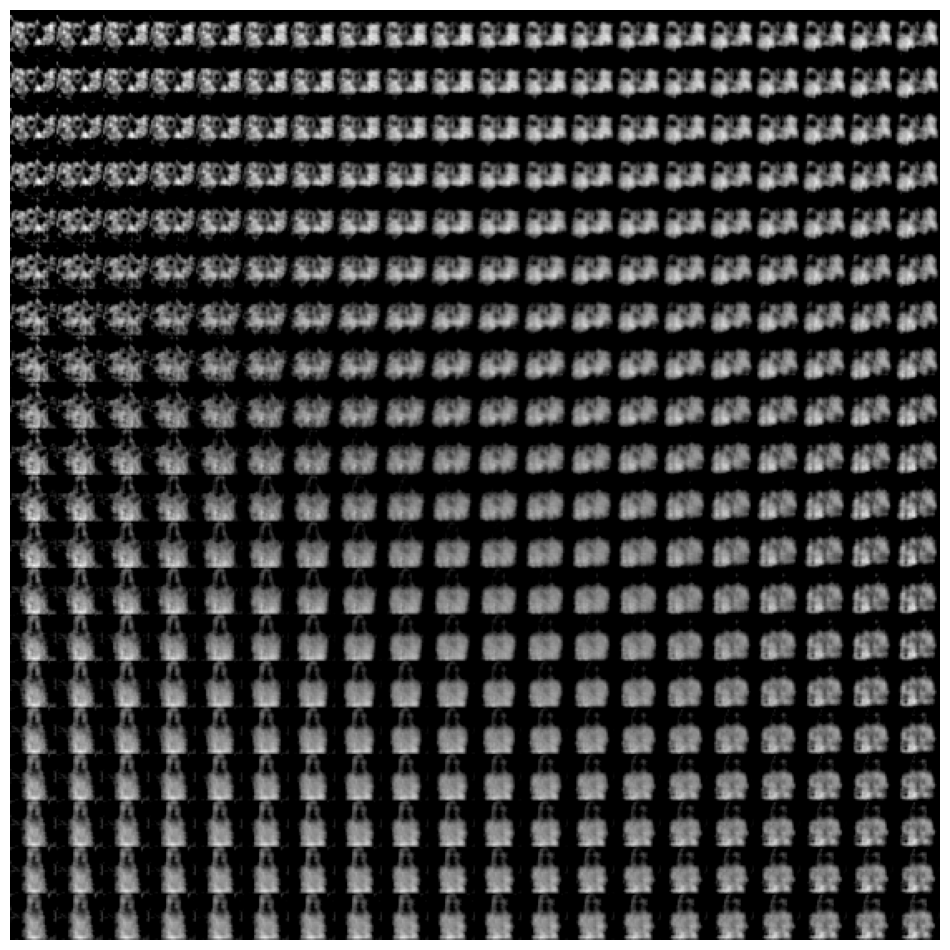

In [25]:
@torch.no_grad()
def plot_reconstructed(model, label, xrange=(-2, 2), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    print("Latent space for class: ", train_dataset.classes[label])
    SIZE = 28
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(DEVICE)
            cond = torch.zeros(1, model.num_classes).to(DEVICE)
            cond[:, label] = 1
            # latent_dim from prior init for model
            recon_samples = model.decoder_pass(z, 1, cond).cpu()

            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = recon_samples

            
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")
    plt.show()

range = 2
for class_label in [1, 2, 5, 8]:
    plot_reconstructed(cvae_loaded, label=class_label, xrange=(-range, range), yrange=(-range, range), N=20)

### CVAE with SVHN dataset

In [12]:
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(np.unique(svhn_train_data.labels))
NUM_EPOCHS = 30

# Tensorboard
cvae_svhn_tboard = utils.make_tboard_logs("cvae_svhn")
in_size = [int(svhn_train_data.data.shape[1]), int(svhn_train_data.data.shape[2]), int(svhn_train_data.data.shape[3])]
feature_dims = [16, 32]
latent_dim = 2
k_size = 5
conv_types = ["ConvUpsample", "ConvTranspose"]

# Model

cvae_svhn = CondConvVAE(
    in_size=in_size, feature_dims=feature_dims, latent_dim=latent_dim, 
    k_size=k_size, pool=True, batchnorm=True, act_name="relu",
    num_classes=NUM_CLASSES
)

cvae_svhn = cvae_svhn.to(DEVICE)
print(f"Model num parameters: {utils.count_parameters(cvae_svhn)}")

/home/user/gomezruizs0/CL/CudaLab_SGR_PS/Session05/tboard_logs/cvae_svhn
Model num parameters: 54061


In [ ]:
cvae_svhn_optimizer = torch.optim.Adam(cvae_svhn.parameters(), lr = LR)
cvae_svhn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cvae_svhn_optimizer, patience=5, factor=0.9, verbose=True)
cvae_svhn_train_loss, cvae_svhn_val_loss, cvae_svhn_val_loss_recon, cvae_svhn_val_loss_vae, cvae_svhn_loss_iters = cvae_train_model(cvae_svhn, 
    cvae_svhn_optimizer, cvae_svhn_scheduler, convvae_loss, svhn_train_loader, svhn_test_loader, 10, DEVICE, "recons/cvae_svhn10_",
    cvae_svhn_tboard)

Epoch 1 || Iter 144 || Mean loss: 515.23150: 100%|██████████| 144/144 [00:16<00:00,  8.67it/s]
Epoch 2 || Iter 144 || Mean loss: 513.73540: 100%|██████████| 144/144 [00:16<00:00,  8.99it/s]
Epoch 3 || Iter 144 || Mean loss: 512.57722: 100%|██████████| 144/144 [00:16<00:00,  8.98it/s]
Epoch 4 || Iter 144 || Mean loss: 512.48245: 100%|██████████| 144/144 [00:16<00:00,  8.91it/s]
Epoch 5 || Iter 144 || Mean loss: 511.84014: 100%|██████████| 144/144 [00:16<00:00,  8.96it/s]
Epoch 6 || Iter 144 || Mean loss: 512.50052: 100%|██████████| 144/144 [00:16<00:00,  8.94it/s]
Epoch 7 || Iter 144 || Mean loss: 512.12305: 100%|██████████| 144/144 [00:16<00:00,  8.97it/s]
Epoch 8 || Iter 144 || Mean loss: 512.02723: 100%|██████████| 144/144 [00:16<00:00,  8.91it/s]
Epoch 9 || Iter 144 || Mean loss: 511.46635: 100%|██████████| 144/144 [00:16<00:00,  8.93it/s]
Epoch 10 || Iter 144 || Mean loss: 510.30867: 100%|██████████| 144/144 [00:16<00:00,  8.93it/s]

Training completed after 3.44 minutes


In [ ]:
utils.save_model(cvae_svhn, cvae_svhn_optimizer, 30, [cvae_svhn_train_loss, cvae_svhn_val_loss, cvae_svhn_val_loss_recon, cvae_svhn_val_loss_vae, cvae_svhn_loss_iters])

In [15]:
cvae_svhn = CondConvVAE(
    in_size=in_size, feature_dims=feature_dims, latent_dim=latent_dim, 
    k_size=k_size, pool=True, batchnorm=True, act_name="relu",
    num_classes=NUM_CLASSES
)

cvae_svhn_optimizer = torch.optim.Adam(cvae_svhn.parameters(), lr = LR)

cvae_svhn, cvae_svhn_optimizer, _, _ = utils.load_model(cvae_svhn, cvae_svhn_optimizer, "./models/checkpoint_CondConvVAE_epoch_30.pth")

cvae_svhn = cvae_svhn.to(DEVICE)

Plots generated from class:  0


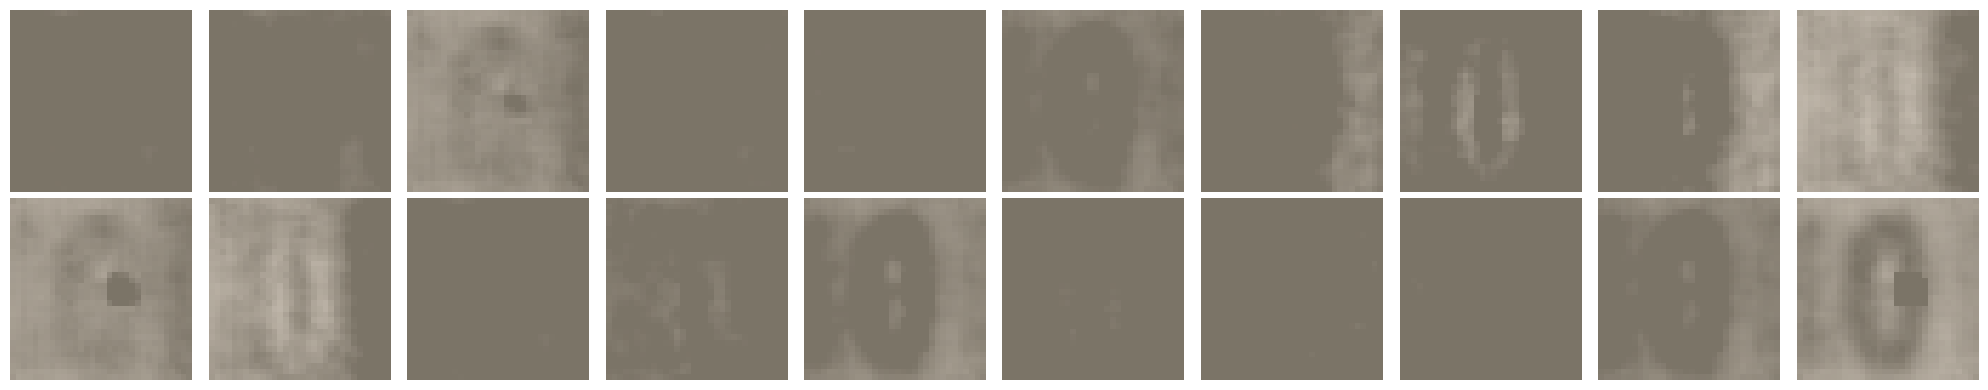

Plots generated from class:  1


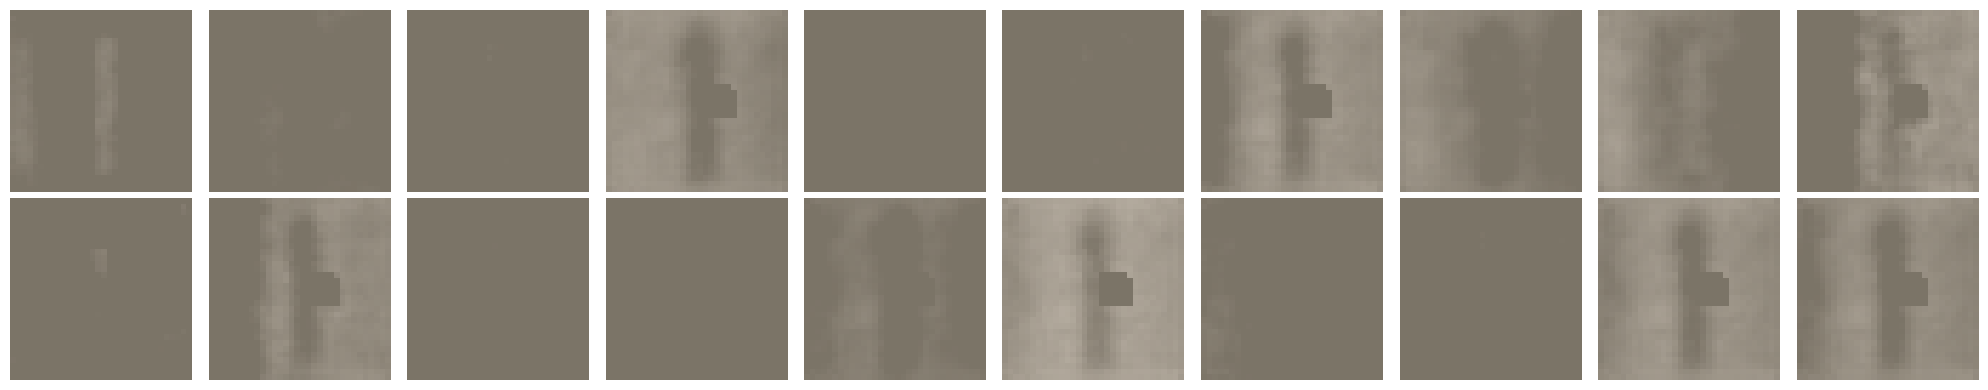

Plots generated from class:  2


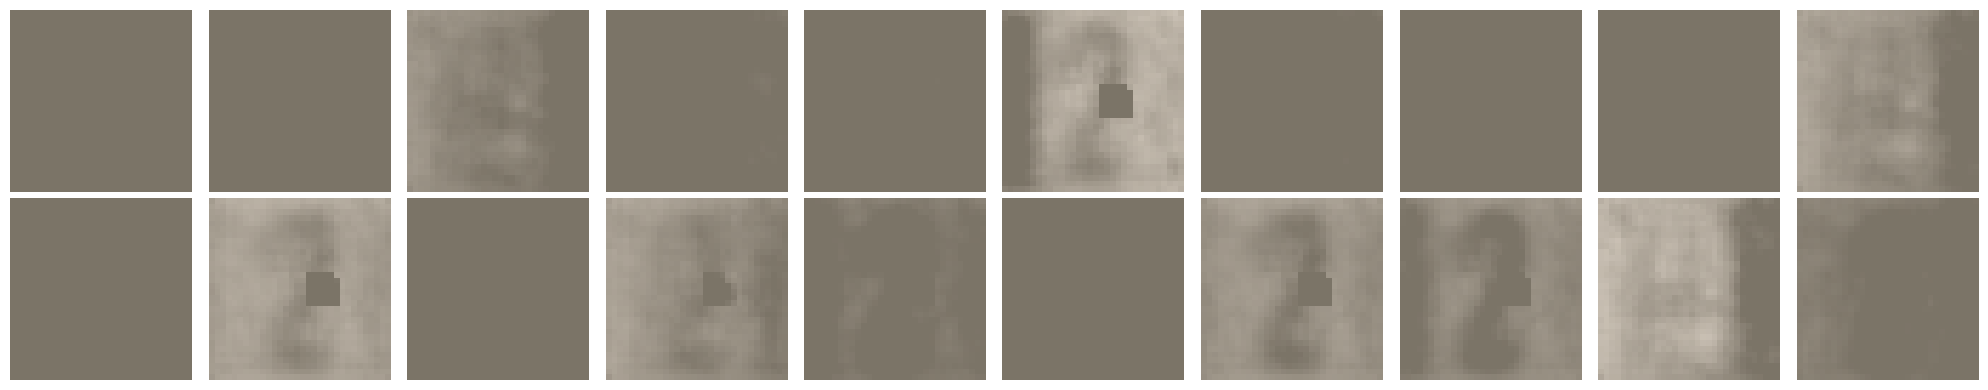

Plots generated from class:  3


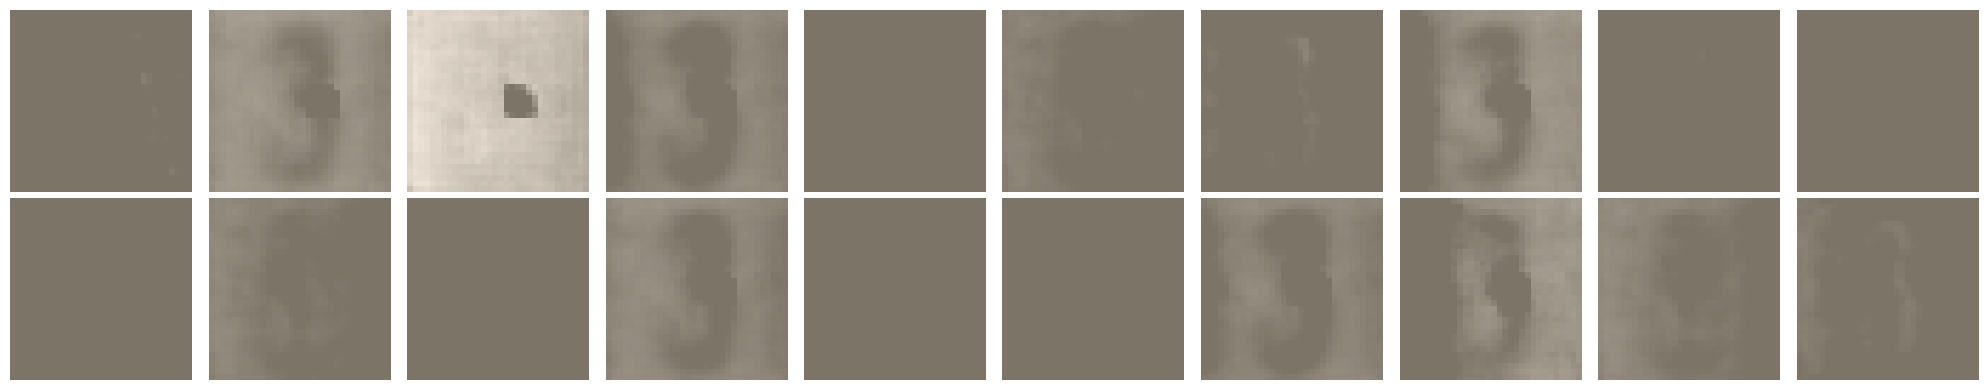

Plots generated from class:  4


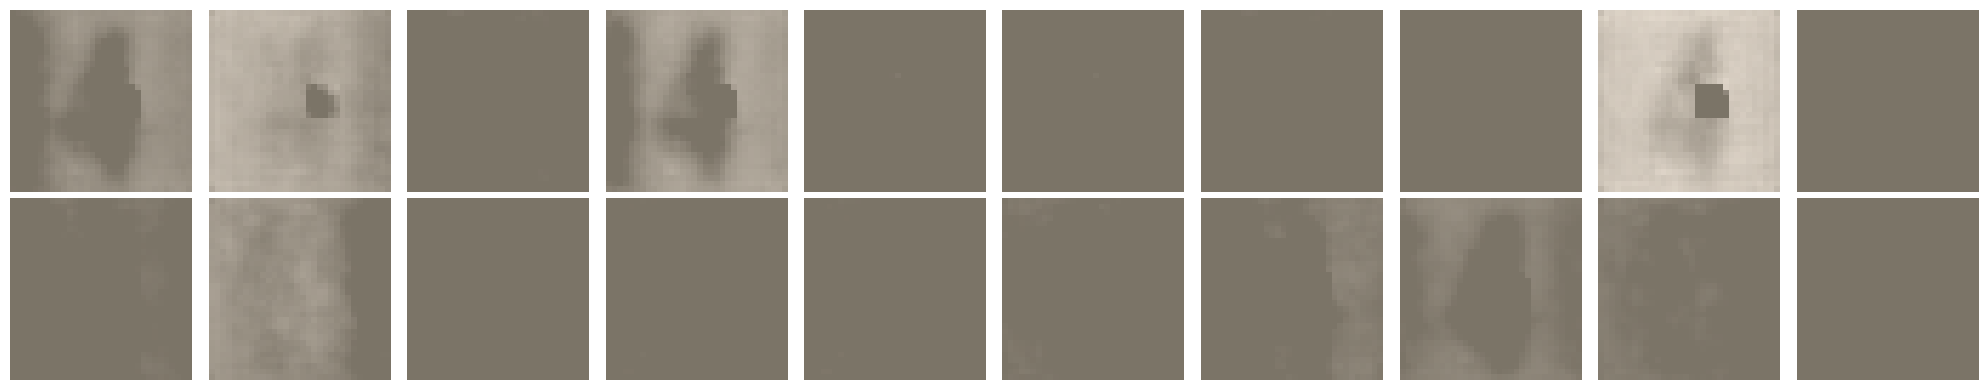

Plots generated from class:  5


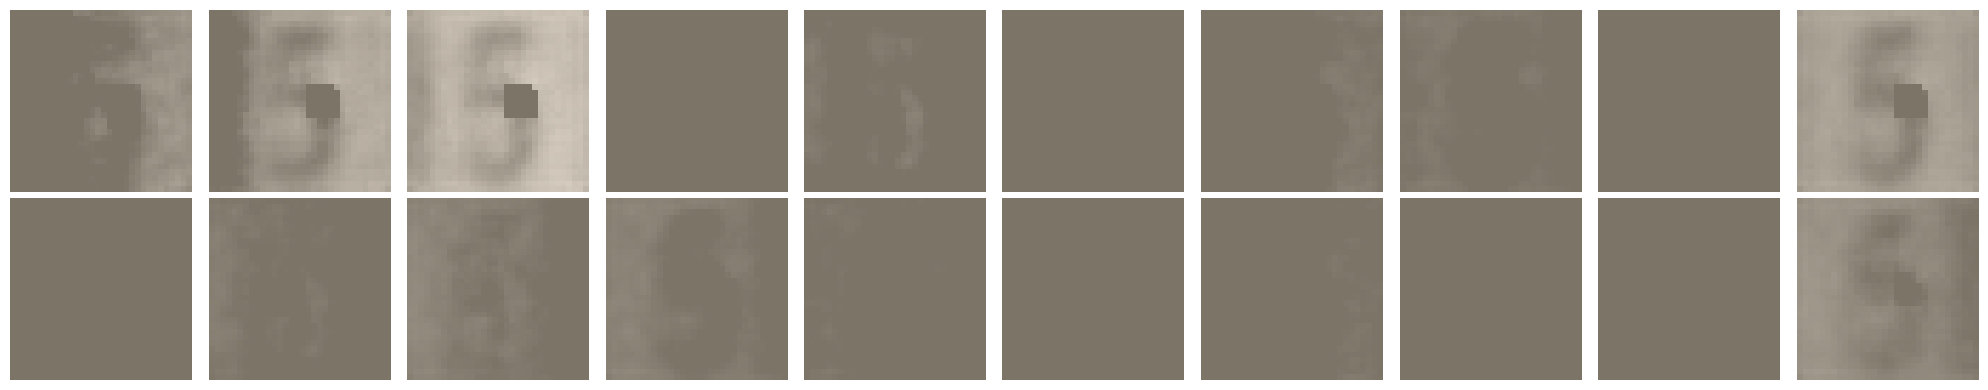

Plots generated from class:  6


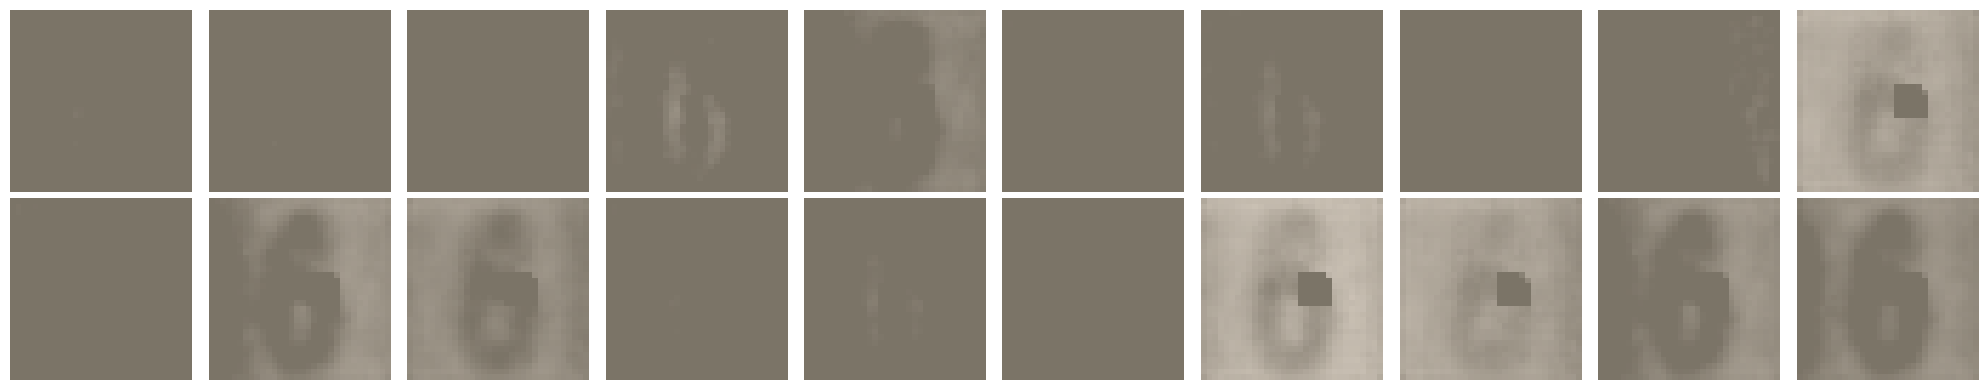

Plots generated from class:  7


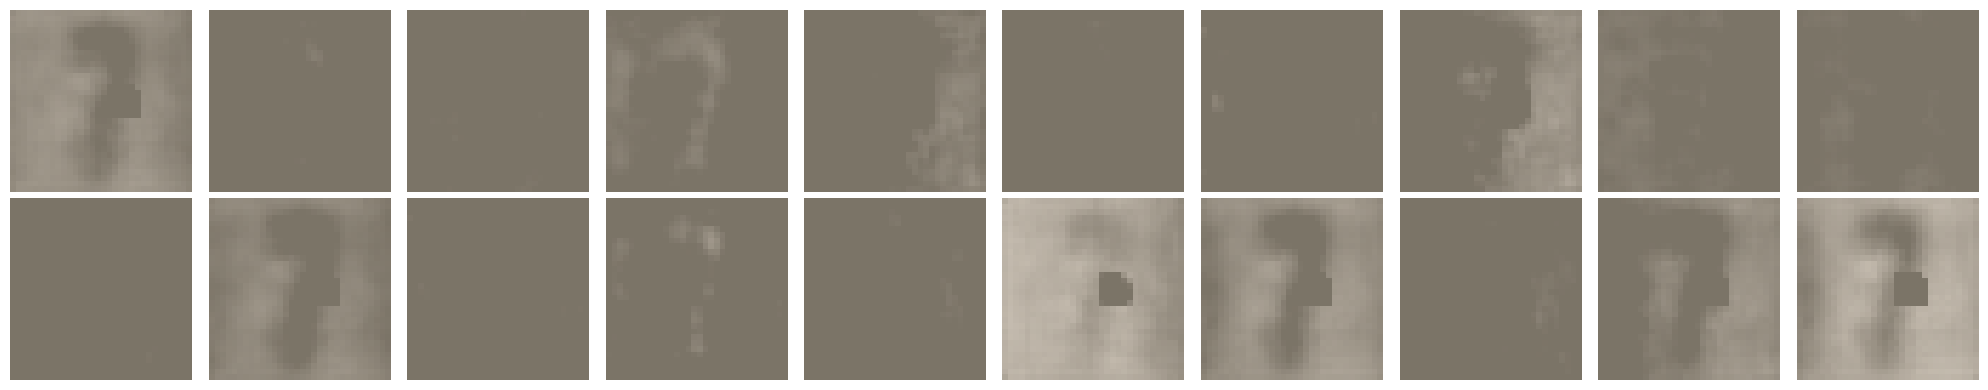

Plots generated from class:  8


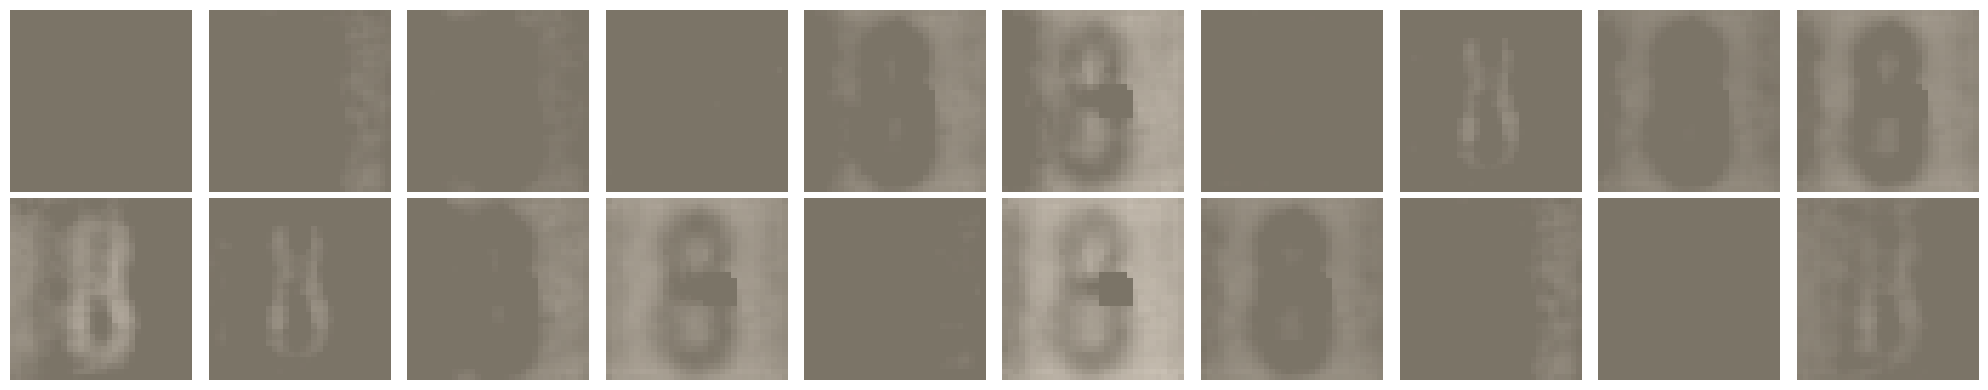

Plots generated from class:  9


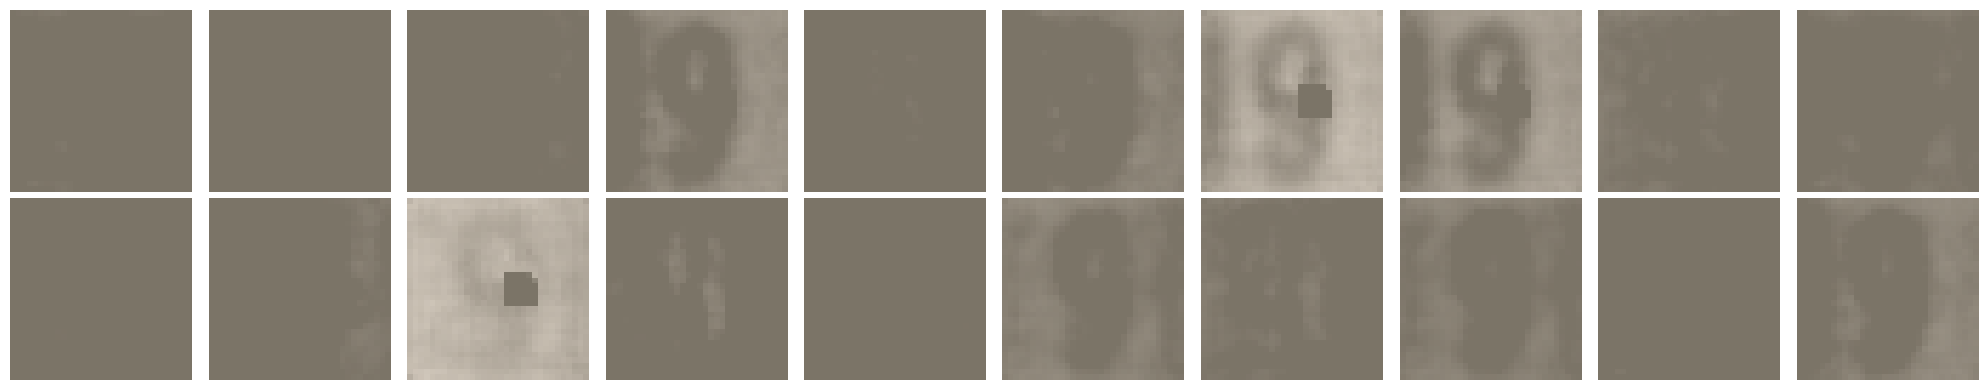

In [19]:
def plot_generated_by_label(model, label, in_size):
    with torch.no_grad():
        num_samples = 20
        # Doing the one hot encoding for the desired class (label)
        cond = torch.zeros(num_samples, model.num_classes).to(DEVICE)
        cond[:, label] = 1
        # latent_dim from prior init for model
        samples = torch.randn(num_samples, latent_dim).to(DEVICE)
        recon_samples = model.decoder_pass(samples, num_samples, cond).cpu()
        # save_image(recon_samples.view(num_samples, *cvae.in_size),
        #             f'./recons/recons_c5_class_{label}.png')

    recons = recon_samples.view(num_samples, *in_size)
    plt.figure(figsize=(10*2, 2*2))
    for i in range(num_samples):
        plt.subplot(2,10,i+1)
        img = recons[i, 0]
        if img.shape[0] == 1:
            plt.imshow(img.cpu(), cmap="gray")
        else:
            mean = np.array([0.485, 0.456, 0.406])[:, None, None]
            std = np.array([0.229, 0.224, 0.225])[:, None, None]
            img = img * std + mean
            plt.imshow(img.cpu().permute(1, 2, 0))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

for class_idx, c in enumerate(np.unique(svhn_train_data.labels)):
    print("Plots generated from class: ", c)
    plot_generated_by_label(cvae_svhn, class_idx, in_size)

By adding the mean and multiplying with the std every picture gets illuminated in a beige sort of way. Some numbers are reasonably generated while others are just black and completely unrecognisable. There seems to be an artifacts right in the middle of the picture. We could find this artifacts in other runs of the same model as well, but we can not explain why this happens.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


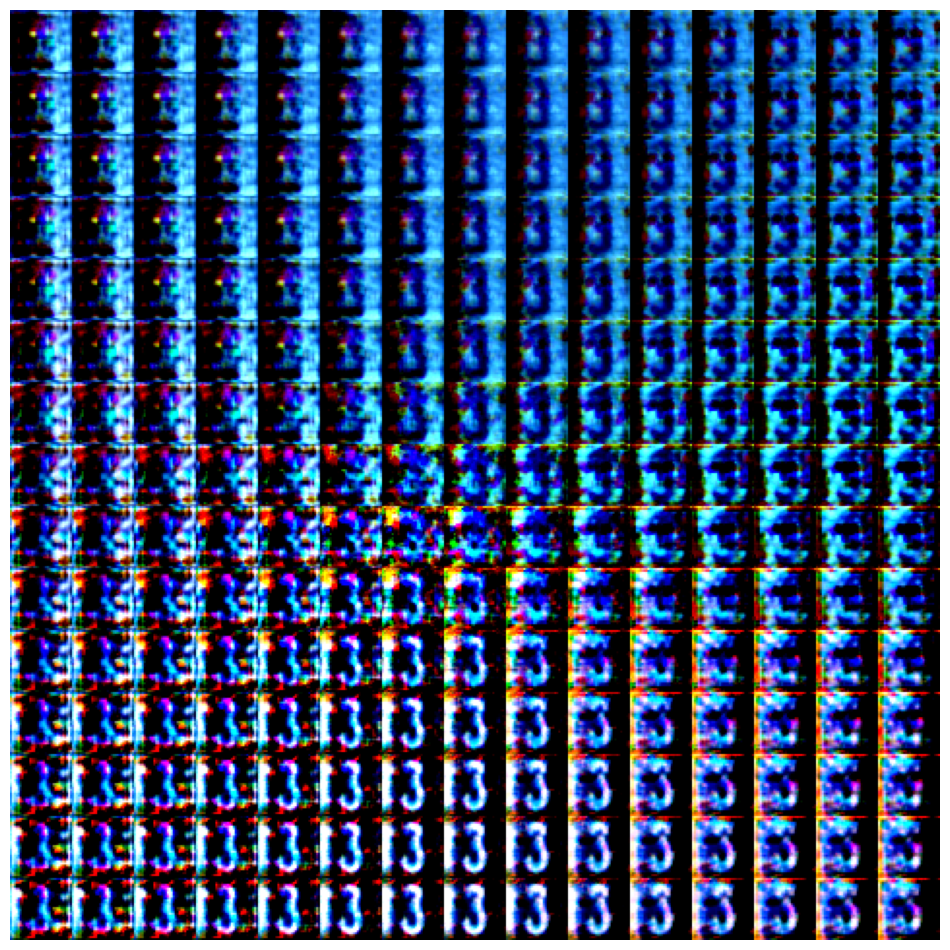

In [20]:
@torch.no_grad()
def plot_reconstructed(model, label, xrange=(-3, 3), yrange=(-2, 2), N=12, in_size=[1, 28, 28], normalize=False):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = in_size[-1]
    grid = np.empty((in_size[0], N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(DEVICE)
            cond = torch.zeros(1, model.num_classes).to(DEVICE)
            cond[:, label] = 1
            # latent_dim from prior init for model
            recon_samples = model.decoder_pass(z, 1, cond).cpu()

            grid[:, (N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = recon_samples
            
    plt.figure(figsize=(12,20))
    if grid.shape[0] == 3 and normalize == True:
        mean = np.array([0.485, 0.456, 0.406])[:, None, None]
        std = np.array([0.229, 0.224, 0.225])[:, None, None]
        grid = grid * std + mean
        print(grid.shape)
    plt.imshow(grid.transpose(1, 2, 0), extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")

range = 2
plot_reconstructed(cvae_svhn, label=3, xrange=(-range, range), yrange=(-range, range), N=15, in_size=in_size)

Here is the example of exploring the latent space of the label 3. This example here is without adding mean and multiplying by the std. While some part of the latent space is reasonably generating a 3, other parts are just random shapes. This represents our results for the above generation of the labels as well, as only some part of the latent space seems to generate a "good" result.

 - d) Make a quantitative comparison between models using the Fréchet Inception Distance: https://arxiv.org/abs/1706.08500

In [18]:
# load both models 
in_size = [int(svhn_train_data.data.shape[1]), int(svhn_train_data.data.shape[2]), int(svhn_train_data.data.shape[3])]
feature_dims = [16, 32]
latent_dim = 2
k_size = 5
conv_types = ["ConvUpsample", "ConvTranspose"]
NUM_CLASSES = len(np.unique(svhn_train_data.labels))

# create convVAE model
convvae_model = ConvVAE(
    in_size=in_size, feature_dims=feature_dims, latent_dim=latent_dim, 
    k_size=k_size, pool=True, batchnorm=True, act_name="relu",
    upconvtype=conv_types[0]
)

convvae_optimizer = torch.optim.Adam(convvae_model.parameters(), lr = LR)
# load model
convvae_model, convvae_optimizer, epoch, stats = utils.load_model(convvae_model, convvae_optimizer, "./models/checkpoint_ConvVAE_epoch_30.pth")

# create  cond conv VAE model
cvae_svhn_model = CondConvVAE(
    in_size=in_size, feature_dims=feature_dims, latent_dim=latent_dim, 
    k_size=k_size, pool=True, batchnorm=True, act_name="relu",
    num_classes=NUM_CLASSES)

cvae_svhn_optimizer = torch.optim.Adam(cvae_svhn_model.parameters(), lr = LR)
# load model
cvae_svhn_model, cvae_svhn_optimizer, epoch, stats = utils.load_model(cvae_svhn_model, cvae_svhn_optimizer, "./models/checkpoint_CondConvVAE_epoch_30.pth")

In [61]:
from scipy import linalg
# from: https://github.com/bioinf-jku/TTUR/blob/master/fid.py
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            # raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real
    # print("covmean:", covmean)
    # print(np.trace(sigma1) + np.trace(sigma2))

    tr_covmean = np.trace(covmean)

    return np.linalg.norm(diff)**2 + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [62]:
# compute FID:
with torch.no_grad():
    for images, labels in svhn_test_loader:
        images = images[:2]
        labels = labels[:2]
        one_hot_labels = utils.one_hot(labels, NUM_CLASSES)
        # Forward pass
        outs_cvae_svhn = cvae_svhn_model(images, one_hot_labels)
        outs_convvae = convvae_model(images)
        out, mu1, logvar1 = outs_cvae_svhn
        out, mu2, logvar2 = outs_convvae
        # print(((mu1-mu2)**2).mean())
        print("Frechet distance computed between Conv CVAE, and Conv VAE models on SVHN dataset:")
        print(calculate_frechet_distance(
            mu1.detach().numpy(), logvar1.detach().numpy(), 
            mu2.detach().numpy(), logvar2.detach().numpy()
            ))

        # Only one batch
        break
    # print(mu1.max())
    # print(mu2.max())

Frechet distance computed between Conv CVAE, and Conv VAE models on SVHN dataset:
-21.661010327889052


As seen, we are obtaining a negative Frechet distance when comparing this two models. By the name itself, a distance shouldn't be negative, thus we believe somehow this models aren't comparable by this FID measurement. And how could we interpret it anyway? We would expect a smaller distance for similar models, thus the one which means and covariance matrices are similar to one another. Therefore we do a measurement of this type in the following cell:

In [67]:
diff_mu = np.linalg.norm(mu1 - mu2) ** 2
diff_cov = np.linalg.norm(logvar1 - logvar2) ** 2
print("Mean squared difference of the means: ", diff_mu)
print("Mean squared difference of the covariance matrices: ", diff_cov)

Mean squared difference of the means:  13.702916291295878
Mean squared difference of the covariance matrices:  2.6478070211079654


In this case our measure is just directly taking into account the norm of the covariance matrices obtained of the evaluation of each model, as well as their mean. As we can see, we obtain quite high values though, specially for the means, which we would technically expect to be very similar if both models were correctly generating/reconstrucing the images properly. As displayed in the previous plots, we could observe that for example the conditional model was able to generate numbers quite similar as expected in a good portion of the displayed latent space, thus we believe the Conditional Convolutional VAE is better than the regular Convolutional VAE. And it makes sense, since they both have the same architecture, but one of them has extra information of the correct label to be generated.


 - Extra point:
   - Train a beta-VAE using ResNet-based encoders and decoders.
   - Encoder is a ResNet-18
   - Decoder is the mirrored version of the encoder
   - Compare this model with the previous ones,

In [12]:
importlib.reload(network_samples)
class ResNet18Encoder(nn.Module):

    def __init__(self, block, layers, in_size):
        super(ResNet18Encoder,self).__init__()
        self.inplanes = 64
        self.in_size = in_size
        self.height = in_size[2] // (2**4)
        self.width = in_size[3] // (2**4)
        # set kernel of first conv to 3 and stride and padding to one because otherwise images gets too small
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 2),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        # max pool differnet dimension otherwise strange dimensions
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        res_block = []
        res_block.append(self._make_enc_layer(block, 64, layers[0], stride = 1))
        res_block.append(self._make_enc_layer(block, 128, layers[1], stride = 2))
        res_block.append(self._make_enc_layer(block, 256, layers[2], stride = 2))
        res_block.append(self._make_enc_layer(block, 512, layers[3], stride = 2))
        self.resnetblock = nn.Sequential(*res_block)
        self.avgpool = nn.AdaptiveAvgPool2d((self.height, self.width))
        self.fc = nn.Linear(512 * self.height * self.width, 1000)
        
    def _make_enc_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.resnetblock(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), 512 * self.height * self.width)
        out = self.fc(out)
        return out

class ResNet18Decoder(nn.Module):
    def __init__(self, block, layers, in_size) -> None:
        super().__init__()
        self.inplanes = 512
        self.in_size = in_size
        self.height = in_size[2] // (2**4)
        self.width = in_size[3] // (2**4)
        self.conv1 = nn.Sequential(
                        nn.Conv2d(64, 3, kernel_size = 5, stride = 1, padding = 2),
                        nn.BatchNorm2d(3),
                        nn.ReLU())
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        res_block = []
        res_block.append(self._make_dec_layer(block, 512, layers[3], stride = 1))
        res_block.append(self._make_dec_layer(block, 256, layers[2], stride = 2))
        res_block.append(self._make_dec_layer(block, 128, layers[1], stride = 2))
        res_block.append(self._make_dec_layer(block, 64, layers[0], stride = 2))
        self.resnetblock = nn.Sequential(*res_block)
        self.dec_fc = nn.Linear(1000, 512 * self.height * self.width)
        
    def _make_dec_layer(self, block, planes, blocks, stride=1):
        upsample = None

        if stride != 1 or self.inplanes != planes:
            upsample = nn.Sequential(
                nn.Upsample(scale_factor=stride),
                nn.Conv2d(in_channels=self.inplanes, out_channels=planes, kernel_size=1, stride=1),
                nn.BatchNorm2d(planes),
            )
        layers = []
        self.inplanes = planes
        layers.append(block(self.inplanes, planes, 1, None, upsample))
        for i in range(1, blocks):
            # set stride otherwise it takes the prior stride and downsamples
            layers.append(block(self.inplanes, planes, stride=1))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.dec_fc(x)
        out = out.view(out.size(0), 512, self.height, self.width)
        out = self.resnetblock(out)
        out = self.upsample(out)
        out = self.conv1(out)
        return out

def ResNet18Latent(in_size, latent_dim):
    mu_fc = nn.Linear(in_features=1000, out_features=latent_dim)
    logvar_fc = nn.Linear(in_features=1000, out_features=latent_dim)
    dec_fc = nn.Linear(in_features=latent_dim, out_features=1000)
    return mu_fc, logvar_fc, dec_fc

In [13]:
class ResNetVAE(nn.Module):
    """
    Implementaton of a convolutional variational autoencoder for
    the Street View House Numbers dataset.
    """
    def __init__(self, in_size, latent_dim, num_Blocks=[2,2,2,2]) -> None:
        super().__init__()
        self.in_size = in_size
        
        self.encoder = ResNet18Encoder(block=network_samples.ResidualBlock, layers=num_Blocks, in_size=self.in_size)
        print("Decoder")
        self.decoder = ResNet18Decoder(block=network_samples.ResidualBlock, layers=num_Blocks, in_size=self.in_size)
        self.mu_fc, self.logvar_fc, self.dec_fc = ResNet18Latent(self.in_size, latent_dim)

    def reparameterize(self, mu, logvar):
        # reparameterization trick to sample from the gaussian distr
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def encoder_pass(self, x):
        x_enc = self.encoder(x)
        # pass through latent 
        mu = self.mu_fc(x_enc)
        logvar = self.logvar_fc(x_enc)
        return mu, logvar

    def decoder_pass(self, z, batch_size):
        # pass thorugh decoder bottleneck
        x_dec = self.dec_fc(z)
        # pass thorugh decoder
        x_dec = self.decoder(x_dec)
        return x_dec

    def forward(self, x):
        # pass through encoder
        self.batch_size, ch, h, w = x.shape
        mu, logvar = self.encoder_pass(x)
        # reparameterization trick
        z = self.reparameterize(mu, logvar)
        # pass through decoder
        out = self.decoder_pass(z,  self.batch_size)
        return out, mu, logvar

In [14]:
in_size = [BATCH_SIZE, int(svhn_train_data.data.shape[1]), int(svhn_train_data.data.shape[2]), int(svhn_train_data.data.shape[3])]
print(in_size)
latent_dim = 2

importlib.reload(network_samples);

resnet18vae_model = ResNetVAE(in_size=in_size, latent_dim=latent_dim)

print("ConvVAE params: ", utils.count_parameters(resnet18vae_model))

[512, 3, 32, 32]
Decoder
ConvVAE params:  28006221


In [15]:
def betavae_loss(outs, imgs, beta=0.4, return_full=False):
    out, mu, logvar = outs
    
    r_l = F.mse_loss(out, imgs) * imgs.shape[-1] * imgs.shape[-2]
    kl_l = 0.5 * (logvar.exp() + mu**2 - 1 - logvar).sum(-1).mean()
    loss = beta * kl_l + r_l
    return loss if return_full==False else (loss, kl_l, r_l)

In [16]:
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 30


criterion = betavae_loss

# Tensorboard
resnet18vae_tboard = utils.make_tboard_logs("ResNet18VAE")

resnet18vae_optimizer = torch.optim.Adam(resnet18vae_model.parameters(), lr = LR)
resnet18vae_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resnet18vae_optimizer, patience=5, factor=0.9, verbose=True)
resnet18vae_model = resnet18vae_model.to(DEVICE)
resnet18vae_train_loss, resnet18vae_val_loss, resnet18vae_val_loss_recon, resnet18vae_val_loss_vae, resnet18vae_loss_iters = convvae_train_model(resnet18vae_model, 
    resnet18vae_optimizer, resnet18vae_scheduler, criterion, svhn_train_loader, svhn_test_loader, NUM_EPOCHS, DEVICE, "recons/resnet18vae_",
    resnet18vae_tboard)

/home/user/schwemme/CudaLab_SGR_PS/Session05/tboard_logs/ResNet18VAE


Epoch 1 || Iter 144 || Mean loss: 101391384.30328: 100%|██████████| 144/144 [01:07<00:00,  2.13it/s]
Epoch 2 || Iter 144 || Mean loss: 536.85082: 100%|██████████| 144/144 [01:09<00:00,  2.06it/s]
Epoch 3 || Iter 144 || Mean loss: 532.05703: 100%|██████████| 144/144 [01:09<00:00,  2.06it/s]
Epoch 4 || Iter 144 || Mean loss: 530.83726: 100%|██████████| 144/144 [01:10<00:00,  2.05it/s]
Epoch 5 || Iter 144 || Mean loss: 528.04600: 100%|██████████| 144/144 [01:10<00:00,  2.05it/s]
Epoch 6 || Iter 144 || Mean loss: 527.17940: 100%|██████████| 144/144 [01:10<00:00,  2.06it/s]
Epoch 7 || Iter 144 || Mean loss: 524.32721: 100%|██████████| 144/144 [01:09<00:00,  2.06it/s]
Epoch 8 || Iter 144 || Mean loss: 523.34558: 100%|██████████| 144/144 [01:09<00:00,  2.06it/s]
Epoch 9 || Iter 144 || Mean loss: 521.20900: 100%|██████████| 144/144 [01:10<00:00,  2.06it/s]
Epoch 10 || Iter 144 || Mean loss: 520.45495: 100%|██████████| 144/144 [01:09<00:00,  2.06it/s]
Epoch 11 || Iter 144 || Mean loss: 519.3779

Epoch 00028: reducing learning rate of group 0 to 2.7000e-04.


Epoch 29 || Iter 144 || Mean loss: 513.64305: 100%|██████████| 144/144 [01:09<00:00,  2.06it/s]
Epoch 30 || Iter 144 || Mean loss: 513.45714: 100%|██████████| 144/144 [01:10<00:00,  2.05it/s]

Training completed after 40.13 minutes


In [17]:
utils.save_model(resnet18vae_model, resnet18vae_optimizer, NUM_EPOCHS, [resnet18vae_train_loss, resnet18vae_val_loss, resnet18vae_val_loss_recon, resnet18vae_val_loss_vae, resnet18vae_loss_iters])

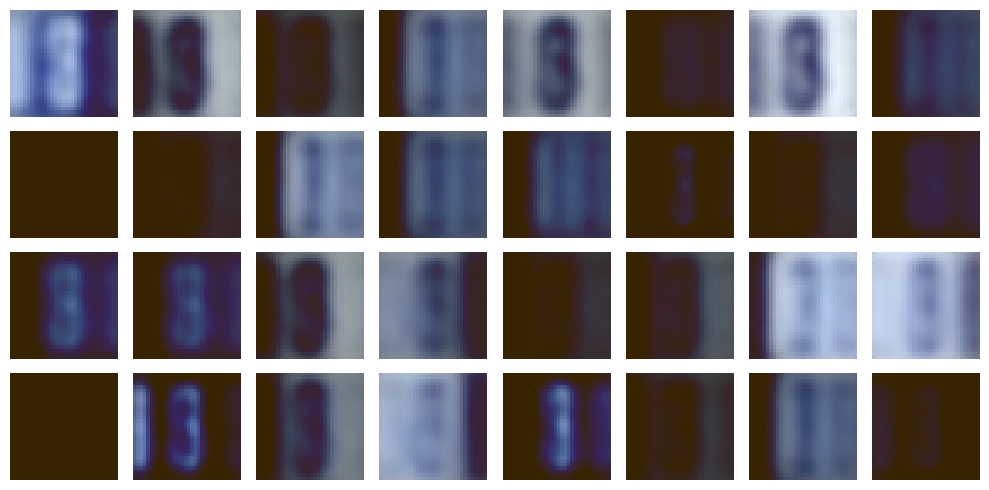

In [20]:
plot_generated_by_label_random_generated_samples(resnet18vae_model)

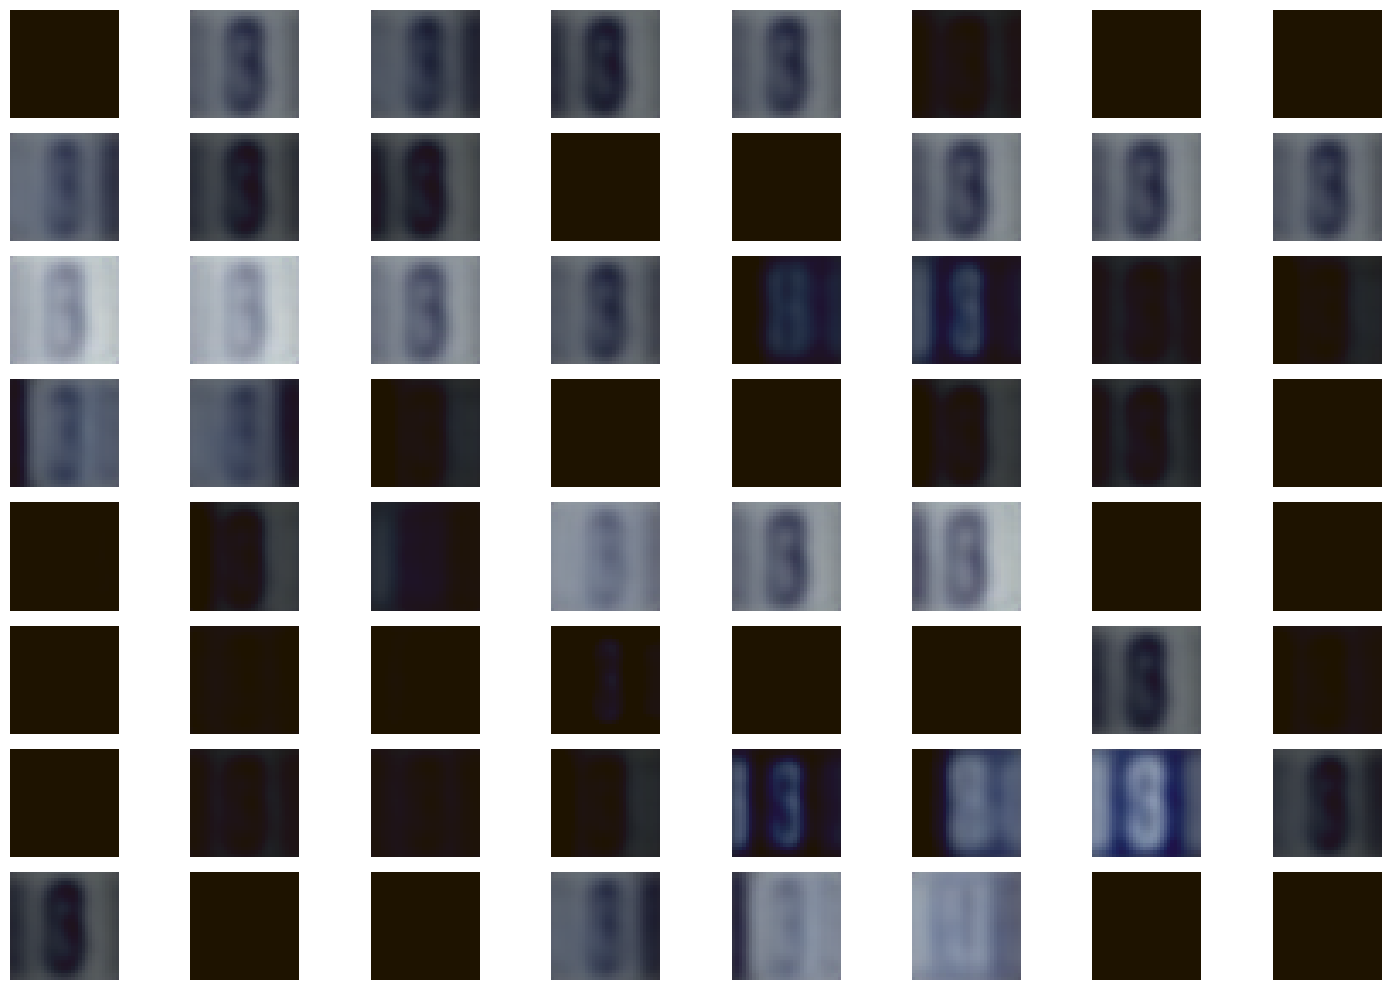

In [23]:
plot_generated_by_label_from_dataset(resnet18vae_model)

We see hard overfit on one type of images (probably where loss was > 1 million in first epoch), so that is where the model then stagnated